## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'spaceNet-full' 
TRANSFORM = 'fourier'
CHANNEL = 'gray'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_fourier_full_spaceNet.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/spaceNet/full/fourier/gray'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 47614,
 3: 54416,
 4: 61218,
 5: 102030,
 6: 156446,
 7: 197258,
 8: 326496,
 9: 421724,
 10: 639388,
 11: 904666,
 12: 1312786,
 13: 1904560,
 14: 2727602,
 15: 3958764,
 16: 5720482,
 17: 8298440,
 18: 11957916,
 19: 17270278,
 20: 25140192,
 21: 36322680,
 22: 52586262,
 23: 65734528,
 24: 32003410}

Running 12760 CDFs


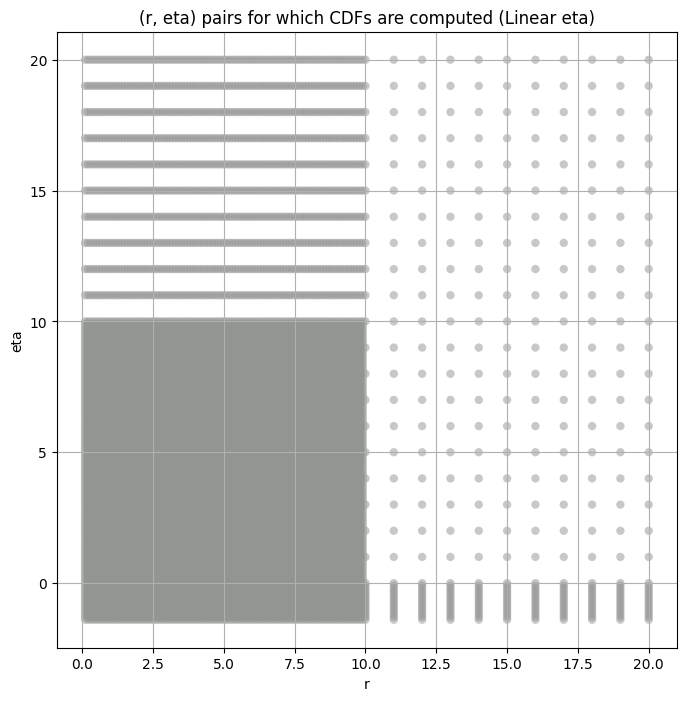

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


100%|██████████| 100000/100000 [01:11<00:00, 1397.17it/s]


Band 5


100%|██████████| 100000/100000 [01:13<00:00, 1369.57it/s]


Band 8


100%|██████████| 100000/100000 [01:14<00:00, 1333.40it/s]


Band 11


100%|██████████| 100000/100000 [01:12<00:00, 1380.73it/s]


Band 14


100%|██████████| 100000/100000 [01:10<00:00, 1409.38it/s]


Band 17


100%|██████████| 100000/100000 [01:15<00:00, 1326.84it/s]


Band 20


100%|██████████| 100000/100000 [01:11<00:00, 1405.89it/s]


Band 23


100%|██████████| 100000/100000 [01:11<00:00, 1393.91it/s]


obs_var    var_lower    var_upper    obs_kurt  kurt_lower  \
band                                                                  
2     1317.523100  1225.378300  1416.404900    5.938153    4.311650   
5      529.166600   484.306500   580.238650   10.238717    6.227644   
8      152.612470   139.443650   167.750700   10.654584    6.318540   
11      38.099050    34.947570    41.571890    9.481829    6.036282   
14      11.219242    10.258306    12.378116   11.123092    6.303248   
17       2.759864     2.472387     3.437130   38.040096    6.955560   
20       0.457457     0.391537     0.766863  212.946980    7.135597   
23       0.108861     0.098681     0.137802   38.076750    4.879170   

      kurt_upper  total_samples  
band                             
2       8.405162        47614.0  
5      16.210070       102030.0  
8      24.114677       326496.0  
11     16.780167       904666.0  
14     29.718310      2727602.0  
17    230.069370      8298440.0  
20    983.588300     25140192.0  
23    234.754040     65734528.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                               
2     1317.523100    1317.523071     1255.085327     1214.754150   
5      529.166600     529.166626      505.678558      492.727020   
8      152.612470     152.612473      145.972992      142.316696   
11      38.099050      38.099049       36.559261       35.710819   
14      11.219242      11.219242       10.746617       10.495022   
17       2.759864       2.759864        2.588251        2.521809   
20       0.457457       0.457457        0.409034        0.398037   
23       0.108861       0.108861        0.103072        0.101013   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2        1182.807739      1155.110962      1108.156738      1068.441040   
5         482.371063       473.606506       459.032501       447.012573   
8         139.420654       136.950836       132.783936       129.254883   
11         35.025200        34.429573        33.413452        32.550121   
14         10.290624        10.113163         9.809871         9.550354   
17          2.468834         2.423400         2.346224         2.280851   
20          0.389416         0.382079         0.369724         0.359329   
23          0.099319         0.097832         0.095257         0.093034   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2         1034.626953      1004.612671       977.675842       908.998352  
5          436.668304       427.246307       418.652618       396.546539  
8          126.146957       123.371338       120.845802       114.305557  
11          31.789806        31.102612        30.472372        28.829311  
14           9.321134         9.114020         8.924015         8.429741  
17           2.223387         2.171693         2.124616         2.002989  
20           0.350226         0.342062         0.334622         0.315437  
23           0.091050         0.089246         0.087584         0.083226

####
Band  2


100%|██████████| 12760/12760 [00:34<00:00, 373.45it/s]


Finding Minimum after computing 12760 CDFs
2 0 0.008493353385480074 1317.5231


100%|██████████| 12760/12760 [00:33<00:00, 382.12it/s]


Finding Minimum after computing 12760 CDFs
2 25 0.008288712338611282 1255.0853


100%|██████████| 12760/12760 [00:32<00:00, 387.25it/s]


Finding Minimum after computing 12760 CDFs
2 50 0.007382659998626959 1214.7542


100%|██████████| 12760/12760 [00:33<00:00, 382.69it/s]


Finding Minimum after computing 12760 CDFs
2 75 0.006787481249399541 1182.8077


100%|██████████| 12760/12760 [00:33<00:00, 385.73it/s]


Finding Minimum after computing 12760 CDFs
2 100 0.0065049305727851725 1155.111


100%|██████████| 12760/12760 [00:33<00:00, 384.76it/s]


Finding Minimum after computing 12760 CDFs
2 150 0.006525084628101974 1108.1567


100%|██████████| 12760/12760 [00:32<00:00, 388.65it/s]


Finding Minimum after computing 12760 CDFs
2 200 0.006734733359432421 1068.441


100%|██████████| 12760/12760 [00:32<00:00, 388.32it/s]


Finding Minimum after computing 12760 CDFs
2 250 0.008450799830221623 1034.627


100%|██████████| 12760/12760 [00:34<00:00, 374.43it/s]


Finding Minimum after computing 12760 CDFs
2 300 0.008706135357261169 1004.6127


100%|██████████| 12760/12760 [00:33<00:00, 383.81it/s]


Finding Minimum after computing 12760 CDFs
2 350 0.009959700204705824 977.67584


100%|██████████| 12760/12760 [00:33<00:00, 386.21it/s]


Finding Minimum after computing 12760 CDFs
2 500 0.01340898292543724 908.99835
Number of samples: 47614, Without approximation : 47614.0


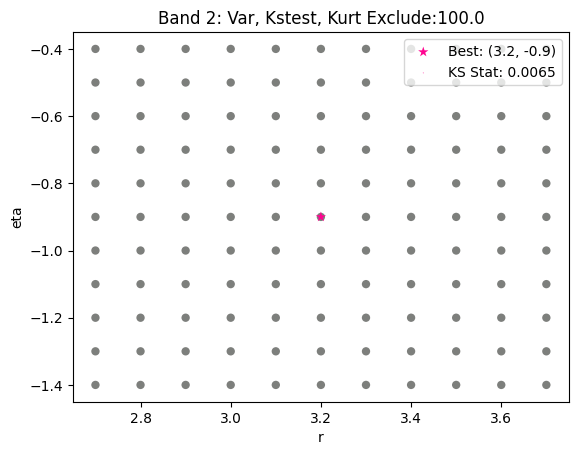

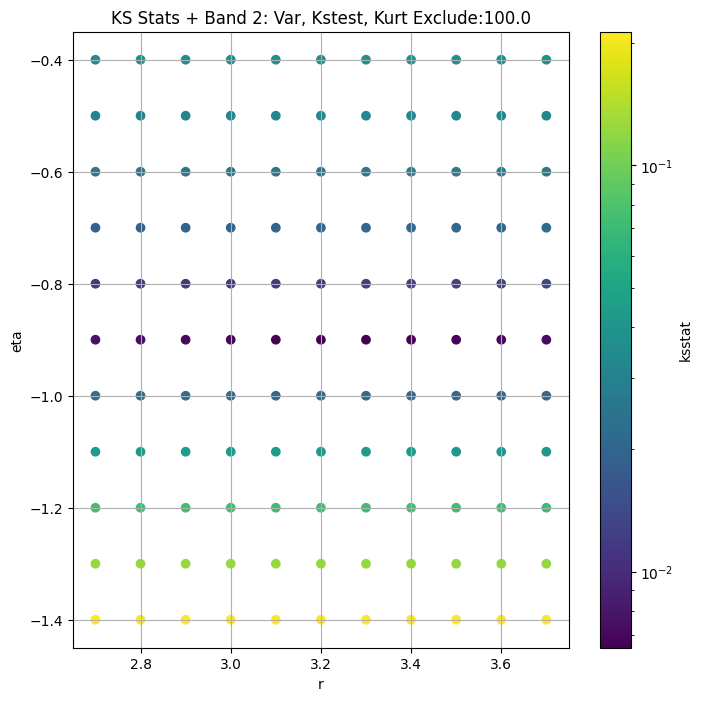

####
Band  5


100%|██████████| 12760/12760 [01:17<00:00, 164.75it/s]


Finding Minimum after computing 12760 CDFs
5 0 0.010547726848027406 529.1666


100%|██████████| 12760/12760 [01:11<00:00, 178.17it/s]


Finding Minimum after computing 12760 CDFs
5 25 0.010146218944508678 505.67856


100%|██████████| 12760/12760 [01:11<00:00, 178.86it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.009913109907638273 492.72702


100%|██████████| 12760/12760 [01:13<00:00, 173.34it/s]


Finding Minimum after computing 12760 CDFs
5 75 0.008803109218183502 482.37106


100%|██████████| 12760/12760 [01:10<00:00, 181.23it/s]


Finding Minimum after computing 12760 CDFs
5 100 0.008975508821818329 473.6065


100%|██████████| 12760/12760 [01:09<00:00, 184.85it/s]


Finding Minimum after computing 12760 CDFs
5 150 0.008806806969284098 459.0325


100%|██████████| 12760/12760 [01:09<00:00, 183.05it/s]


Finding Minimum after computing 12760 CDFs
5 200 0.008649140249272436 447.01257


100%|██████████| 12760/12760 [01:11<00:00, 178.15it/s]


Finding Minimum after computing 12760 CDFs
5 250 0.008657423407292919 436.6683


100%|██████████| 12760/12760 [01:19<00:00, 160.92it/s]


Finding Minimum after computing 12760 CDFs
5 300 0.008720967419585168 427.2463


100%|██████████| 12760/12760 [02:26<00:00, 87.32it/s] 


Finding Minimum after computing 12760 CDFs
5 350 0.008760854310407462 418.65262


100%|██████████| 12760/12760 [03:32<00:00, 60.15it/s] 


Finding Minimum after computing 12760 CDFs
5 500 0.008779412622084315 396.54654
Number of samples: 100000, Without approximation : 102030.0


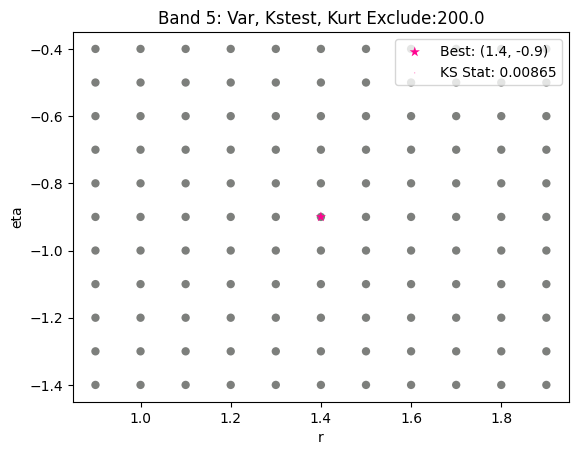

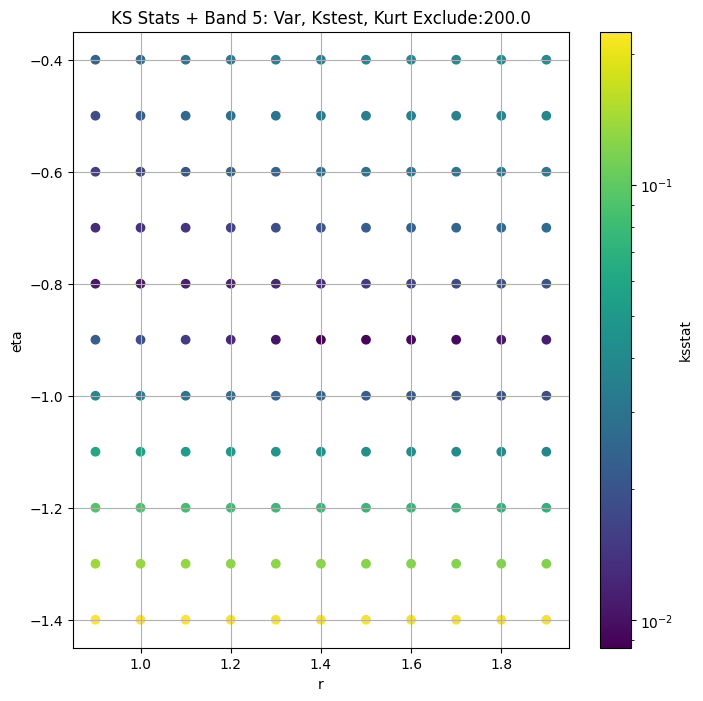

####
Band  8


100%|██████████| 12760/12760 [02:08<00:00, 99.11it/s] 


Finding Minimum after computing 12760 CDFs
8 0 0.008511801204560854 152.61247


100%|██████████| 12760/12760 [01:57<00:00, 108.24it/s]


Finding Minimum after computing 12760 CDFs
8 25 0.009251041368273705 145.97299


100%|██████████| 12760/12760 [01:21<00:00, 156.85it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.008751299144617364 142.3167


100%|██████████| 12760/12760 [00:42<00:00, 296.83it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.008586171661061348 139.42065


100%|██████████| 12760/12760 [00:42<00:00, 299.04it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.008441375582219468 136.95084


100%|██████████| 12760/12760 [00:45<00:00, 277.74it/s]


Finding Minimum after computing 12760 CDFs
8 150 0.008238829497008271 132.78394


100%|██████████| 12760/12760 [00:46<00:00, 276.02it/s]


Finding Minimum after computing 12760 CDFs
8 200 0.007991559016110261 129.25488


100%|██████████| 12760/12760 [00:43<00:00, 296.63it/s]


Finding Minimum after computing 12760 CDFs
8 250 0.007647280598984896 126.14696


100%|██████████| 12760/12760 [00:42<00:00, 300.44it/s]


Finding Minimum after computing 12760 CDFs
8 300 0.007283968570557298 123.37134


100%|██████████| 12760/12760 [00:42<00:00, 300.08it/s]


Finding Minimum after computing 12760 CDFs
8 350 0.007217092570033556 120.8458


100%|██████████| 12760/12760 [00:42<00:00, 298.33it/s]


Finding Minimum after computing 12760 CDFs
8 500 0.007708275008738719 114.30556
Number of samples: 100000, Without approximation : 326496.0


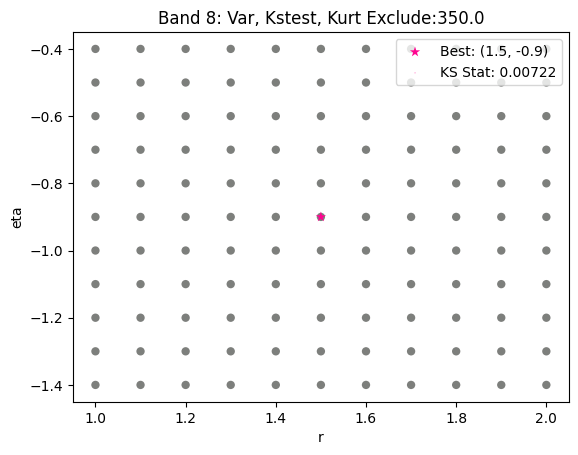

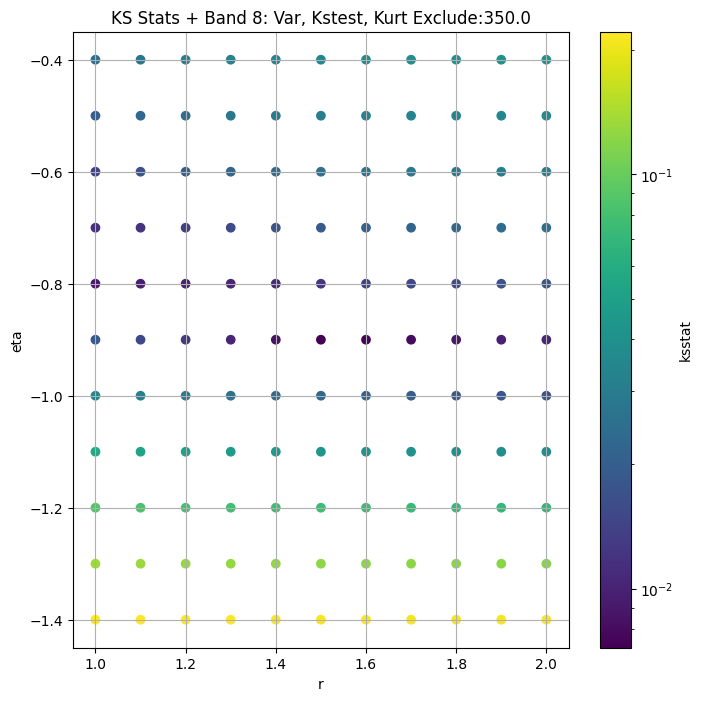

####
Band  11


100%|██████████| 12760/12760 [00:42<00:00, 301.85it/s]


Finding Minimum after computing 12760 CDFs
11 0 0.0076652066306345246 38.09905


100%|██████████| 12760/12760 [00:43<00:00, 291.48it/s]


Finding Minimum after computing 12760 CDFs
11 25 0.008620406989675478 36.55926


100%|██████████| 12760/12760 [00:42<00:00, 299.42it/s]


Finding Minimum after computing 12760 CDFs
11 50 0.008127489101762975 35.71082


100%|██████████| 12760/12760 [00:42<00:00, 299.53it/s]


Finding Minimum after computing 12760 CDFs
11 75 0.007957771119144197 35.0252


100%|██████████| 12760/12760 [00:42<00:00, 300.29it/s]


Finding Minimum after computing 12760 CDFs
11 100 0.007812020341653736 34.429573


100%|██████████| 12760/12760 [00:42<00:00, 297.03it/s]


Finding Minimum after computing 12760 CDFs
11 150 0.007821710617503586 33.413452


100%|██████████| 12760/12760 [00:43<00:00, 295.91it/s]


Finding Minimum after computing 12760 CDFs
11 200 0.0071215469972903955 32.55012


100%|██████████| 12760/12760 [00:42<00:00, 300.77it/s]


Finding Minimum after computing 12760 CDFs
11 250 0.006294299581387053 31.789806


100%|██████████| 12760/12760 [00:42<00:00, 301.25it/s]


Finding Minimum after computing 12760 CDFs
11 300 0.006455030808604878 31.102612


100%|██████████| 12760/12760 [00:42<00:00, 300.92it/s]


Finding Minimum after computing 12760 CDFs
11 350 0.0065717070926528676 30.472372


100%|██████████| 12760/12760 [00:42<00:00, 297.93it/s]


Finding Minimum after computing 12760 CDFs
11 500 0.007727675506909115 28.829311
Number of samples: 100000, Without approximation : 904666.0


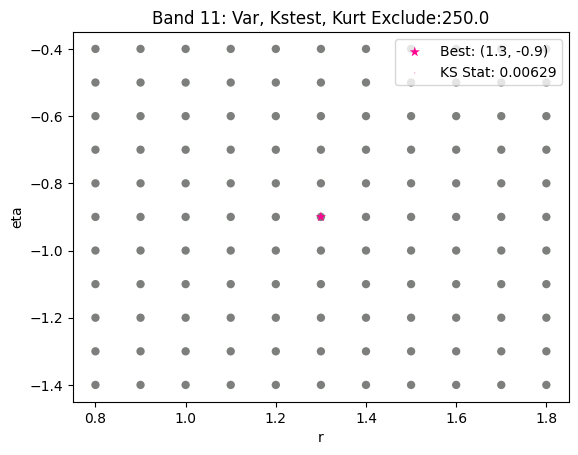

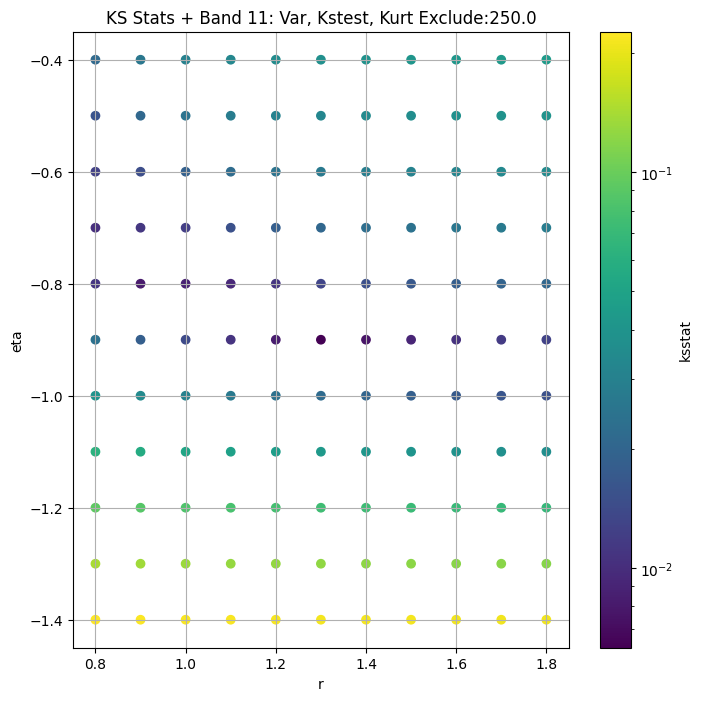

####
Band  14


100%|██████████| 12760/12760 [00:42<00:00, 298.35it/s]


Finding Minimum after computing 12760 CDFs
14 0 0.007551447243749121 11.219242


100%|██████████| 12760/12760 [00:42<00:00, 301.09it/s]


Finding Minimum after computing 12760 CDFs
14 25 0.008187630798553669 10.746617


100%|██████████| 12760/12760 [00:42<00:00, 300.79it/s]


Finding Minimum after computing 12760 CDFs
14 50 0.006988370075280581 10.495022


100%|██████████| 12760/12760 [00:42<00:00, 302.33it/s]


Finding Minimum after computing 12760 CDFs
14 75 0.005700249592520246 10.290624


100%|██████████| 12760/12760 [00:42<00:00, 299.81it/s]


Finding Minimum after computing 12760 CDFs
14 100 0.006640195848774733 10.113163


100%|██████████| 12760/12760 [00:42<00:00, 300.49it/s]


Finding Minimum after computing 12760 CDFs
14 150 0.006713433085556386 9.809871


100%|██████████| 12760/12760 [00:42<00:00, 300.16it/s]


Finding Minimum after computing 12760 CDFs
14 200 0.006181522747896073 9.550354


100%|██████████| 12760/12760 [00:42<00:00, 299.10it/s]


Finding Minimum after computing 12760 CDFs
14 250 0.005904895872828053 9.321134


100%|██████████| 12760/12760 [00:43<00:00, 294.78it/s]


Finding Minimum after computing 12760 CDFs
14 300 0.006173365227979732 9.11402


100%|██████████| 12760/12760 [01:01<00:00, 207.18it/s]


Finding Minimum after computing 12760 CDFs
14 350 0.006243880870654528 8.924015


100%|██████████| 12760/12760 [00:45<00:00, 281.43it/s]


Finding Minimum after computing 12760 CDFs
14 500 0.008062258121512289 8.429741
Number of samples: 100000, Without approximation : 2727602.0


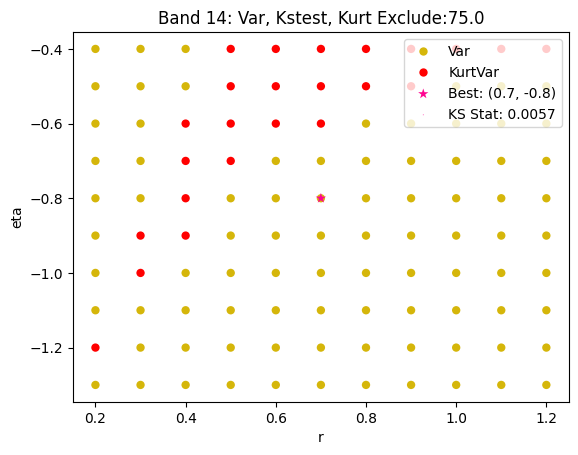

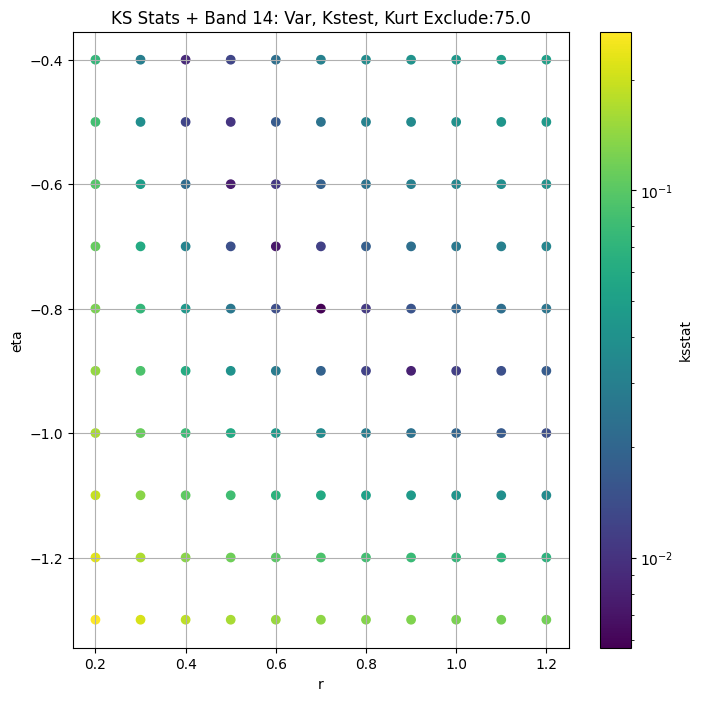

####
Band  17


100%|██████████| 12760/12760 [00:43<00:00, 293.76it/s]


Finding Minimum after computing 12760 CDFs
17 0 0.006339433345972645 2.7598639


100%|██████████| 12760/12760 [00:42<00:00, 297.05it/s]


Finding Minimum after computing 12760 CDFs
17 25 0.004934250524933681 2.5882514


100%|██████████| 12760/12760 [00:42<00:00, 299.33it/s]


Finding Minimum after computing 12760 CDFs
17 50 0.004440242085329449 2.521809


100%|██████████| 12760/12760 [00:42<00:00, 300.89it/s]


Finding Minimum after computing 12760 CDFs
17 75 0.005519423090180081 2.4688344


100%|██████████| 12760/12760 [00:42<00:00, 300.73it/s]


Finding Minimum after computing 12760 CDFs
17 100 0.005664096265727558 2.4234004


100%|██████████| 12760/12760 [00:42<00:00, 301.25it/s]


Finding Minimum after computing 12760 CDFs
17 150 0.005366977315627852 2.3462243


100%|██████████| 12760/12760 [00:42<00:00, 300.61it/s]


Finding Minimum after computing 12760 CDFs
17 200 0.0048252657833155466 2.2808506


100%|██████████| 12760/12760 [00:42<00:00, 300.80it/s]


Finding Minimum after computing 12760 CDFs
17 250 0.004984477130737575 2.2233875


100%|██████████| 12760/12760 [00:42<00:00, 300.16it/s]


Finding Minimum after computing 12760 CDFs
17 300 0.005578657360564621 2.1716933


100%|██████████| 12760/12760 [00:42<00:00, 300.84it/s]


Finding Minimum after computing 12760 CDFs
17 350 0.0061752375042964935 2.1246157


100%|██████████| 12760/12760 [00:43<00:00, 292.63it/s]


Finding Minimum after computing 12760 CDFs
17 500 0.007924014175662797 2.0029893
Number of samples: 100000, Without approximation : 8298440.0


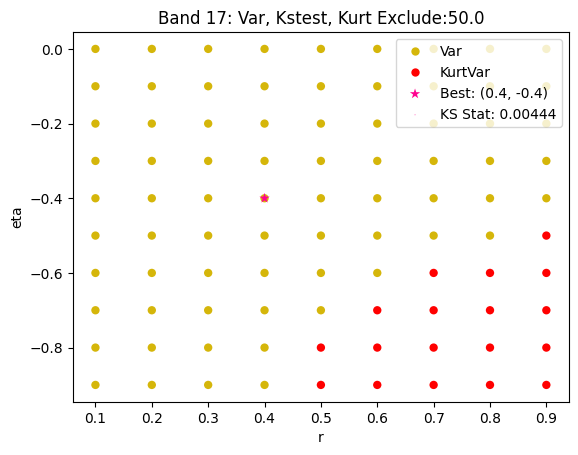

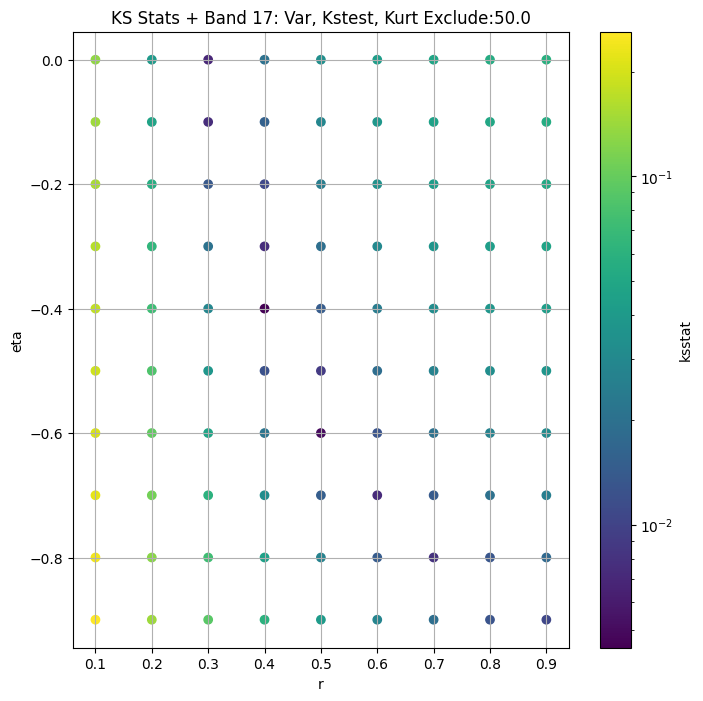

####
Band  20


100%|██████████| 12760/12760 [00:42<00:00, 302.11it/s]


Finding Minimum after computing 12760 CDFs
20 0 0.0031506994279853207 0.45745653


100%|██████████| 12760/12760 [00:42<00:00, 301.72it/s]


Finding Minimum after computing 12760 CDFs
20 25 0.002255273123471402 0.4090342


100%|██████████| 12760/12760 [00:42<00:00, 302.11it/s]


Finding Minimum after computing 12760 CDFs
20 50 0.0023738872114433818 0.3980375


100%|██████████| 12760/12760 [00:42<00:00, 302.14it/s]


Finding Minimum after computing 12760 CDFs
20 75 0.0029833487426698113 0.3894162


100%|██████████| 12760/12760 [00:42<00:00, 299.45it/s]


Finding Minimum after computing 12760 CDFs
20 100 0.003081556397909857 0.3820793


100%|██████████| 12760/12760 [00:43<00:00, 293.58it/s]


Finding Minimum after computing 12760 CDFs
20 150 0.0036881870709856157 0.36972395


100%|██████████| 12760/12760 [00:44<00:00, 288.10it/s]


Finding Minimum after computing 12760 CDFs
20 200 0.004322899327538154 0.3593286


100%|██████████| 12760/12760 [00:43<00:00, 290.06it/s]


Finding Minimum after computing 12760 CDFs
20 250 0.005031747872502379 0.35022637


100%|██████████| 12760/12760 [00:43<00:00, 296.27it/s]


Finding Minimum after computing 12760 CDFs
20 300 0.005624621641670657 0.34206226


100%|██████████| 12760/12760 [00:42<00:00, 299.60it/s]


Finding Minimum after computing 12760 CDFs
20 350 0.00621636059796693 0.33462194


100%|██████████| 12760/12760 [00:42<00:00, 300.57it/s]


Finding Minimum after computing 12760 CDFs
20 500 0.007967174564205926 0.31543675
Number of samples: 100000, Without approximation : 25140192.0


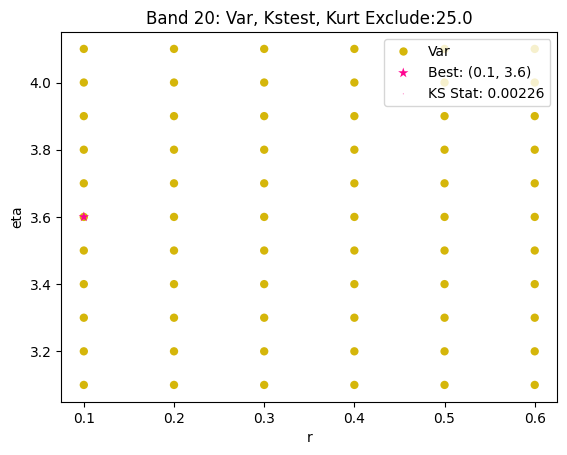

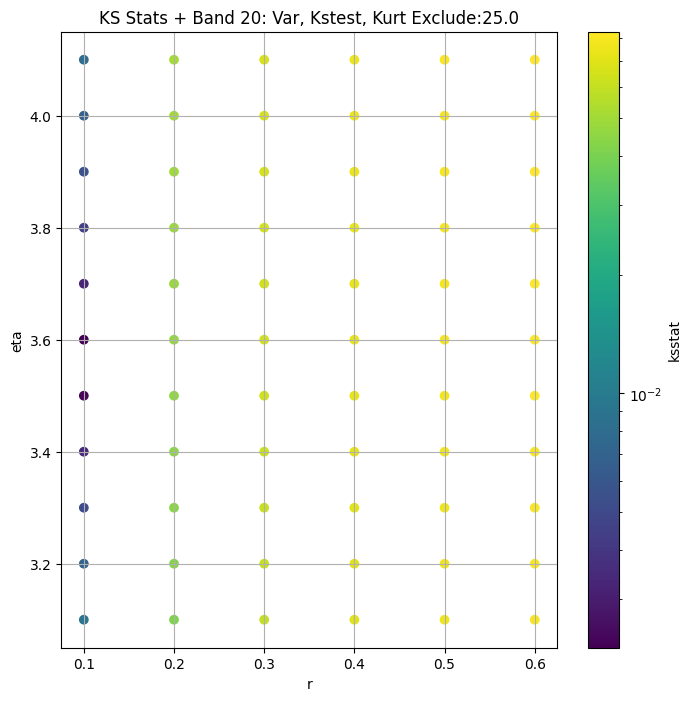

####
Band  23


100%|██████████| 12760/12760 [00:42<00:00, 300.69it/s]


Finding Minimum after computing 12760 CDFs
23 0 0.0028193653226440407 0.10886136


100%|██████████| 12760/12760 [00:42<00:00, 301.87it/s]


Finding Minimum after computing 12760 CDFs
23 25 0.0022049165019991657 0.10307153


100%|██████████| 12760/12760 [00:42<00:00, 300.10it/s]


Finding Minimum after computing 12760 CDFs
23 50 0.0024172290762151105 0.10101319


100%|██████████| 12760/12760 [00:42<00:00, 300.00it/s]


Finding Minimum after computing 12760 CDFs
23 75 0.002954776514675128 0.09931868


100%|██████████| 12760/12760 [00:42<00:00, 300.90it/s]


Finding Minimum after computing 12760 CDFs
23 100 0.003158362981088847 0.09783241


100%|██████████| 12760/12760 [00:42<00:00, 302.23it/s]


Finding Minimum after computing 12760 CDFs
23 150 0.003828637474113883 0.09525742


100%|██████████| 12760/12760 [00:42<00:00, 301.24it/s]


Finding Minimum after computing 12760 CDFs
23 200 0.004449607789676624 0.09303368


100%|██████████| 12760/12760 [00:42<00:00, 300.13it/s]


Finding Minimum after computing 12760 CDFs
23 250 0.005032990821442929 0.09105014


100%|██████████| 12760/12760 [00:42<00:00, 301.78it/s]


Finding Minimum after computing 12760 CDFs
23 300 0.005638811525822907 0.089246124


100%|██████████| 12760/12760 [00:43<00:00, 294.19it/s]


Finding Minimum after computing 12760 CDFs
23 350 0.006192213742604702 0.08758403


100%|██████████| 12760/12760 [00:53<00:00, 238.23it/s]


Finding Minimum after computing 12760 CDFs
23 500 0.007928992721729977 0.083225615
Number of samples: 100000, Without approximation : 65734528.0


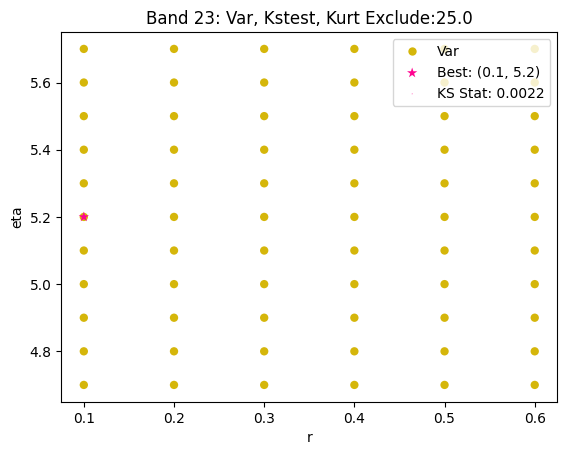

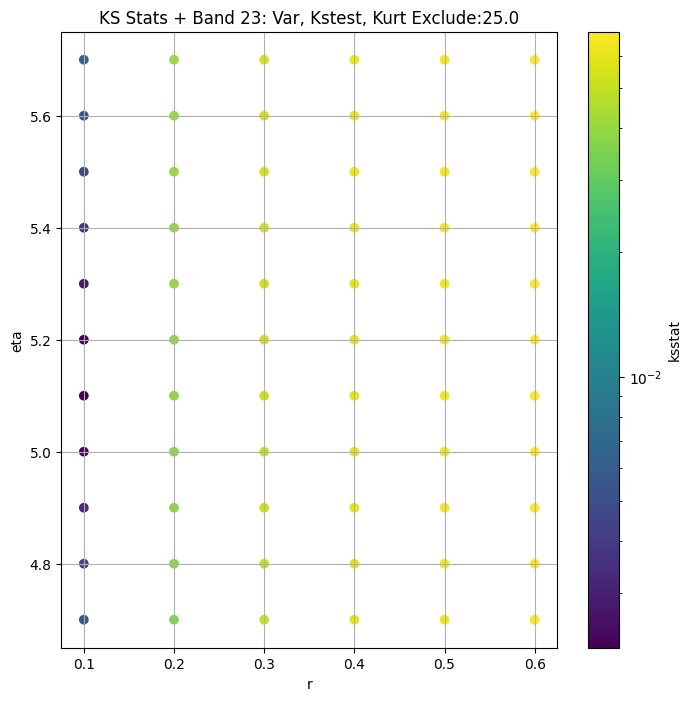

obs_var    var_lower    var_upper    obs_kurt  kurt_lower  \
band                                                                  
2     1317.523100  1225.378300  1416.404900    5.938153    4.311650   
5      529.166600   484.306500   580.238650   10.238717    6.227644   
8      152.612470   139.443650   167.750700   10.654584    6.318540   
11      38.099050    34.947570    41.571890    9.481829    6.036282   
14      11.219242    10.258306    12.378116   11.123092    6.303248   
17       2.759864     2.472387     3.437130   38.040096    6.955560   
20       0.457457     0.391537     0.766863  212.946980    7.135597   
23       0.108861     0.098681     0.137802   38.076750    4.879170   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2       8.405162        47614.0             0.006505        3.2         -0.9   
5      16.210070       102030.0             0.008649        1.4         -0.9   
8      24.114677       326496.0             0.007217        1.5         -0.9   
11     16.780167       904666.0             0.006294        1.3         -0.9   
14     29.718310      2727602.0             0.005700        0.7         -0.8   
17    230.069370      8298440.0             0.004440        0.4         -0.4   
20    983.588300     25140192.0             0.002255        0.1          3.6   
23    234.754040     65734528.0             0.002205        0.1          5.2   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      3.203187e+03                   100.0         1155.111000   
5      9.879908e+02                   200.0          447.012570   
8      2.775865e+02                   350.0          120.845800   
11     6.698871e+01                   250.0           31.789806   
14     8.129588e+00                    75.0           10.290624   
17     1.151886e-01                    50.0            2.521809   
20     1.495063e-18                    25.0            0.409034   
23     2.975689e-20                    25.0            0.103072   

      kstest_stat_cutoff_0.05  
band                           
2                    0.006220  
5                    0.004250  
8                    0.002376  
11                   0.001428  
14                   0.000822  
17                   0.000471  
20                   0.000271  
23                   0.000168

In [ ]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


100%|██████████| 180/180 [00:00<00:00, 525.50it/s]


Finding Minimum after computing 180 CDFs
band 2, 100.0 + 100 = 200, ksstat: 0.007601636237502651, var: 1068.4410400390625


100%|██████████| 180/180 [00:00<00:00, 600.37it/s]


Finding Minimum after computing 180 CDFs
band 2, 100.0 + 75 = 175, ksstat: 0.007312545076846588, var: 1087.543701171875


100%|██████████| 180/180 [00:00<00:00, 613.08it/s]


Finding Minimum after computing 180 CDFs
band 2, 100.0 + 50 = 150, ksstat: 0.007012195100973007, var: 1108.15673828125


100%|██████████| 180/180 [00:00<00:00, 580.99it/s]


Finding Minimum after computing 180 CDFs
band 2, 100.0 + 25 = 125, ksstat: 0.006760953331219621, var: 1130.4979248046875


100%|██████████| 180/180 [00:00<00:00, 598.04it/s]


Finding Minimum after computing 180 CDFs
band 2, 100.0 + 0 = 100, ksstat: 0.0065049305727851725, var: 1155.1109619140625


100%|██████████| 180/180 [00:00<00:00, 563.26it/s]


Finding Minimum after computing 180 CDFs
band 2, 100.0 + -25 = 75, ksstat: 0.007333035409390093, var: 1182.8077392578125


100%|██████████| 180/180 [00:00<00:00, 575.25it/s]


Finding Minimum after computing 180 CDFs
band 2, 100.0 + -50 = 50, ksstat: 0.008661975643621408, var: 1214.754150390625


100%|██████████| 180/180 [00:00<00:00, 588.67it/s]


Finding Minimum after computing 180 CDFs
band 2, 100.0 + -75 = 25, ksstat: 0.010337999169034093, var: 1255.0853271484375


100%|██████████| 180/180 [00:00<00:00, 583.56it/s]


Finding Minimum after computing 180 CDFs
band 2, 100.0 + -100 = 0, ksstat: 0.01275313898751844, var: 1317.5230712890625
Number of samples: 47614, Without approximation : 47614.0


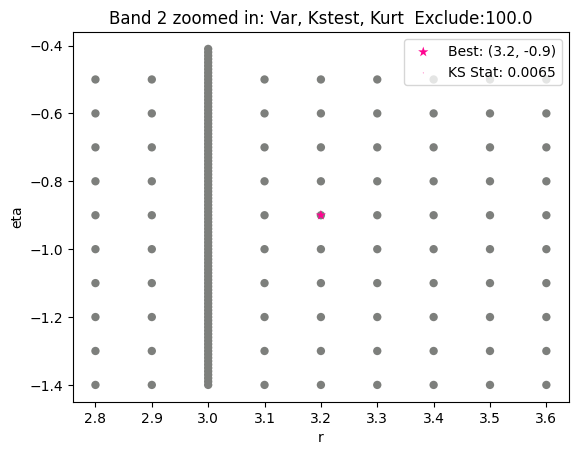

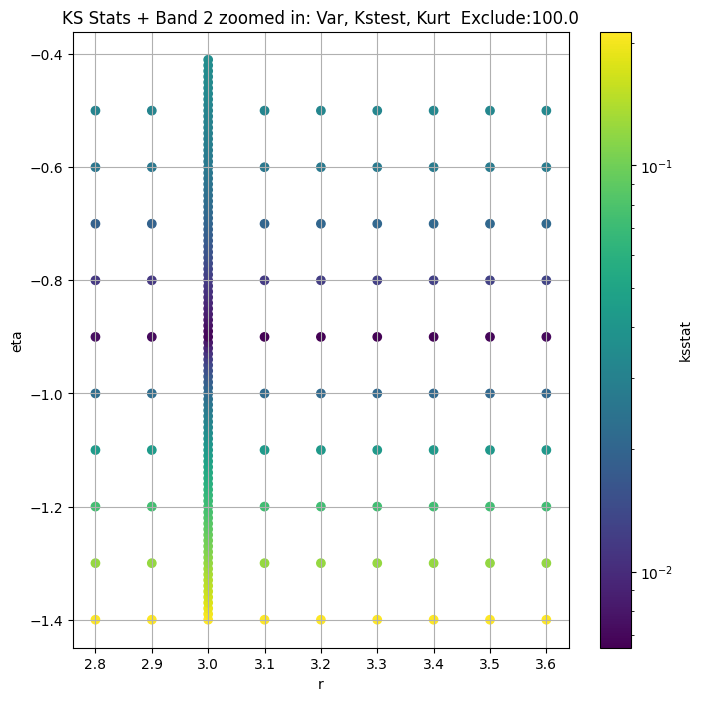

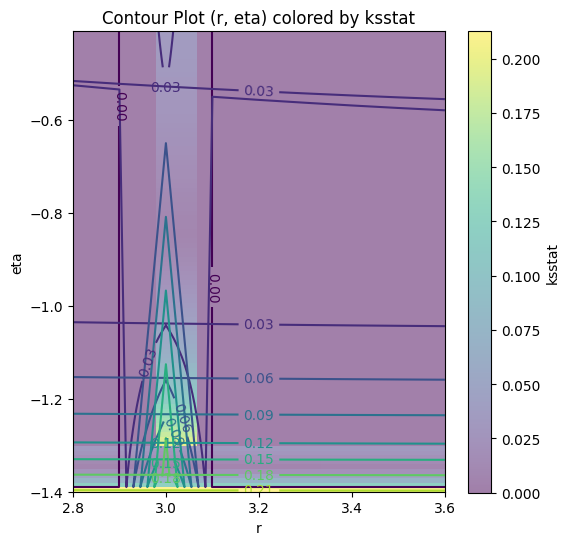

Band 5


100%|██████████| 1900/1900 [00:08<00:00, 216.14it/s]


Finding Minimum after computing 1900 CDFs
band 5, 200.0 + 100 = 300, ksstat: 0.008496510013038194, var: 427.2463073730469


100%|██████████| 1900/1900 [00:08<00:00, 227.96it/s]


Finding Minimum after computing 1900 CDFs
band 5, 200.0 + 75 = 275, ksstat: 0.008427869947303601, var: 431.84442138671875


100%|██████████| 1900/1900 [00:07<00:00, 241.77it/s]


Finding Minimum after computing 1900 CDFs
band 5, 200.0 + 50 = 250, ksstat: 0.008322035917166959, var: 436.6683044433594


100%|██████████| 1900/1900 [00:06<00:00, 292.83it/s]


Finding Minimum after computing 1900 CDFs
band 5, 200.0 + 25 = 225, ksstat: 0.008251076374268917, var: 441.7012634277344


100%|██████████| 1900/1900 [00:06<00:00, 292.03it/s]


Finding Minimum after computing 1900 CDFs
band 5, 200.0 + 0 = 200, ksstat: 0.008339403089794861, var: 447.0125732421875


100%|██████████| 1900/1900 [00:06<00:00, 294.13it/s]


Finding Minimum after computing 1900 CDFs
band 5, 200.0 + -25 = 175, ksstat: 0.00823957417419141, var: 452.7931823730469


100%|██████████| 1900/1900 [00:06<00:00, 271.85it/s]


Finding Minimum after computing 1900 CDFs
band 5, 200.0 + -50 = 150, ksstat: 0.008555527148701114, var: 459.0325012207031


100%|██████████| 1900/1900 [00:07<00:00, 241.18it/s]


Finding Minimum after computing 1900 CDFs
band 5, 200.0 + -75 = 125, ksstat: 0.008533528891512265, var: 465.8699645996094


100%|██████████| 1900/1900 [00:06<00:00, 301.98it/s]


Finding Minimum after computing 1900 CDFs
band 5, 200.0 + -100 = 100, ksstat: 0.0085150351553408, var: 473.60650634765625
Number of samples: 100000, Without approximation : 102030.0


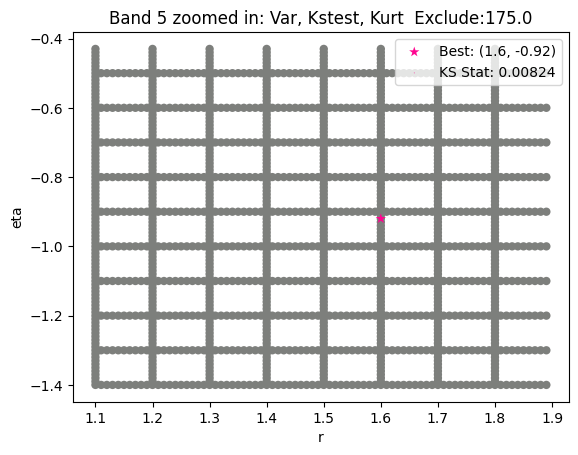

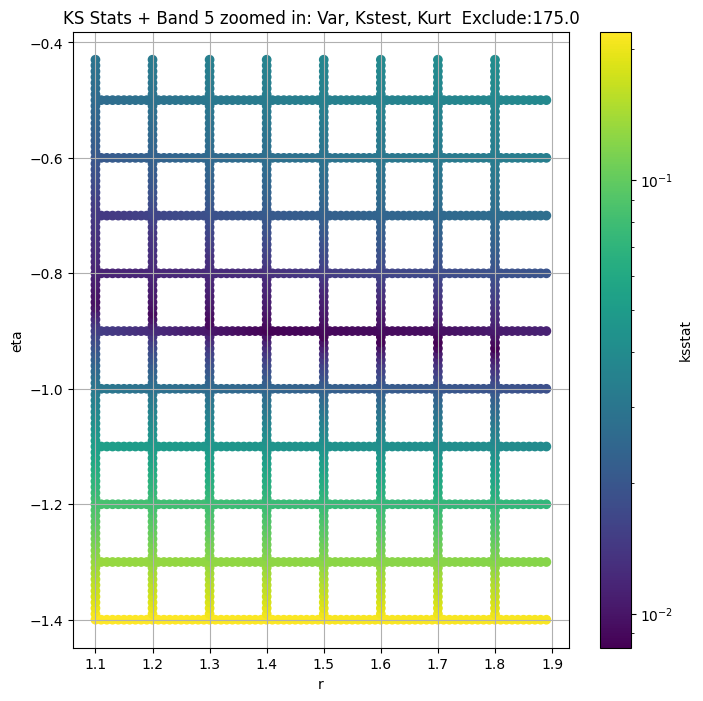

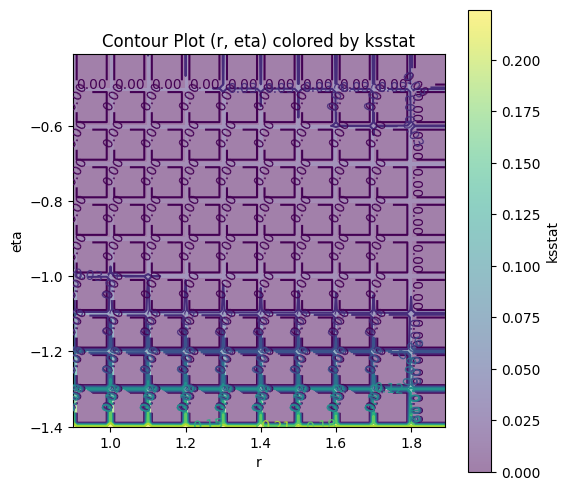

Band 8


100%|██████████| 1800/1800 [00:06<00:00, 297.61it/s]


Finding Minimum after computing 1800 CDFs
band 8, 350.0 + 100 = 450, ksstat: 0.007227089485411842, var: 116.34693145751953


100%|██████████| 1800/1800 [00:06<00:00, 297.74it/s]


Finding Minimum after computing 1800 CDFs
band 8, 350.0 + 75 = 425, ksstat: 0.007102843797388125, var: 117.4162368774414


100%|██████████| 1800/1800 [00:05<00:00, 302.22it/s]


Finding Minimum after computing 1800 CDFs
band 8, 350.0 + 50 = 400, ksstat: 0.006896950236019106, var: 118.51785278320312


100%|██████████| 1800/1800 [00:05<00:00, 302.35it/s]


Finding Minimum after computing 1800 CDFs
band 8, 350.0 + 25 = 375, ksstat: 0.006824951953857017, var: 119.6567153930664


100%|██████████| 1800/1800 [00:06<00:00, 298.45it/s]


Finding Minimum after computing 1800 CDFs
band 8, 350.0 + 0 = 350, ksstat: 0.007000090628124012, var: 120.8458023071289


100%|██████████| 1800/1800 [00:05<00:00, 302.04it/s]


Finding Minimum after computing 1800 CDFs
band 8, 350.0 + -25 = 325, ksstat: 0.007078334207839099, var: 122.08081817626953


100%|██████████| 1800/1800 [00:05<00:00, 301.08it/s]


Finding Minimum after computing 1800 CDFs
band 8, 350.0 + -50 = 300, ksstat: 0.007134399201860486, var: 123.371337890625


100%|██████████| 1800/1800 [00:06<00:00, 299.21it/s]


Finding Minimum after computing 1800 CDFs
band 8, 350.0 + -75 = 275, ksstat: 0.0071416287285895885, var: 124.72505950927734


100%|██████████| 1800/1800 [00:05<00:00, 300.77it/s]


Finding Minimum after computing 1800 CDFs
band 8, 350.0 + -100 = 250, ksstat: 0.007138470245397377, var: 126.14695739746094
Number of samples: 100000, Without approximation : 326496.0


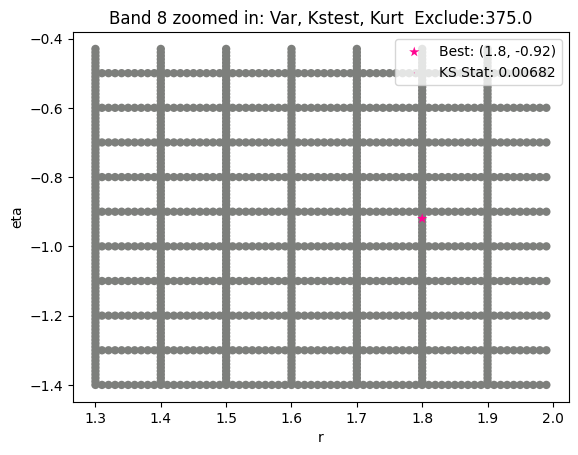

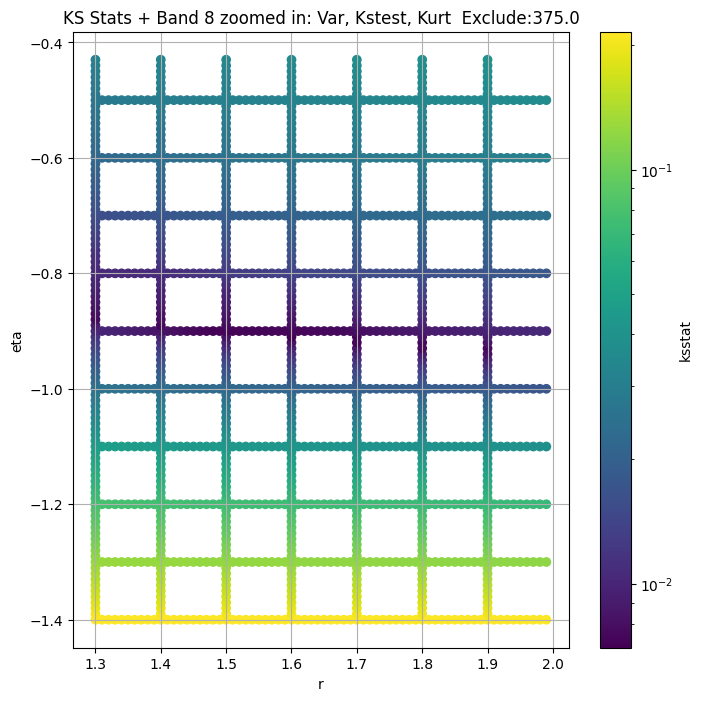

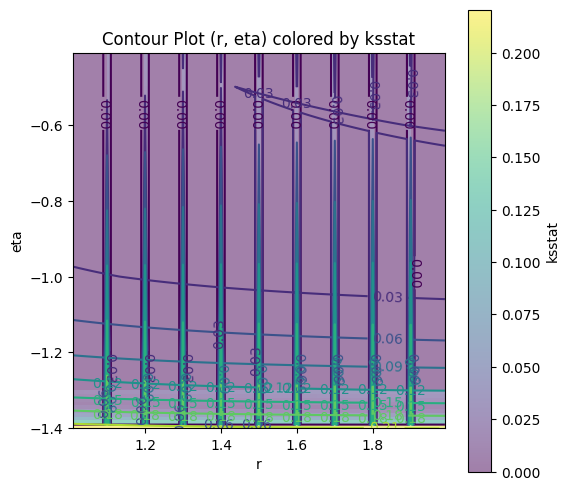

Band 11


100%|██████████| 1800/1800 [00:06<00:00, 279.16it/s]


Finding Minimum after computing 1800 CDFs
band 11, 250.0 + 100 = 350, ksstat: 0.006338942367621336, var: 30.47237205505371


100%|██████████| 1800/1800 [00:05<00:00, 301.54it/s]


Finding Minimum after computing 1800 CDFs
band 11, 250.0 + 75 = 325, ksstat: 0.006172816136745696, var: 30.781301498413086


100%|██████████| 1800/1800 [00:06<00:00, 299.50it/s]


Finding Minimum after computing 1800 CDFs
band 11, 250.0 + 50 = 300, ksstat: 0.006321084711967018, var: 31.102611541748047


100%|██████████| 1800/1800 [00:06<00:00, 299.63it/s]


Finding Minimum after computing 1800 CDFs
band 11, 250.0 + 25 = 275, ksstat: 0.00630886965611277, var: 31.438026428222656


100%|██████████| 1800/1800 [00:05<00:00, 302.28it/s]


Finding Minimum after computing 1800 CDFs
band 11, 250.0 + 0 = 250, ksstat: 0.006294299581387053, var: 31.789806365966797


100%|██████████| 1800/1800 [00:06<00:00, 293.85it/s]


Finding Minimum after computing 1800 CDFs
band 11, 250.0 + -25 = 225, ksstat: 0.006281858379147742, var: 32.159751892089844


100%|██████████| 1800/1800 [00:05<00:00, 300.64it/s]


Finding Minimum after computing 1800 CDFs
band 11, 250.0 + -50 = 200, ksstat: 0.006490074180220962, var: 32.55012130737305


100%|██████████| 1800/1800 [00:05<00:00, 300.92it/s]


Finding Minimum after computing 1800 CDFs
band 11, 250.0 + -75 = 175, ksstat: 0.006613815313890825, var: 32.96699905395508


100%|██████████| 1800/1800 [00:05<00:00, 302.18it/s]


Finding Minimum after computing 1800 CDFs
band 11, 250.0 + -100 = 150, ksstat: 0.006858018643782882, var: 33.4134521484375
Number of samples: 100000, Without approximation : 904666.0


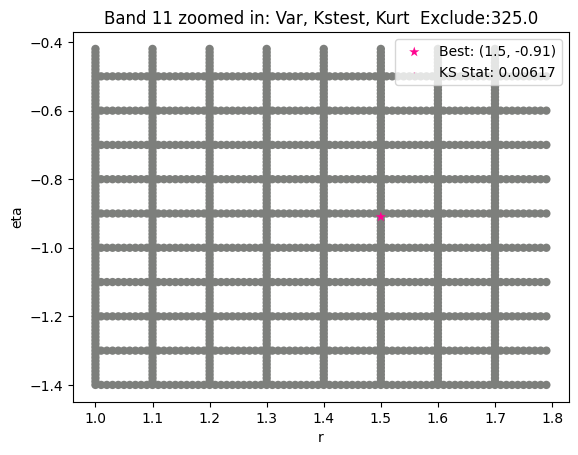

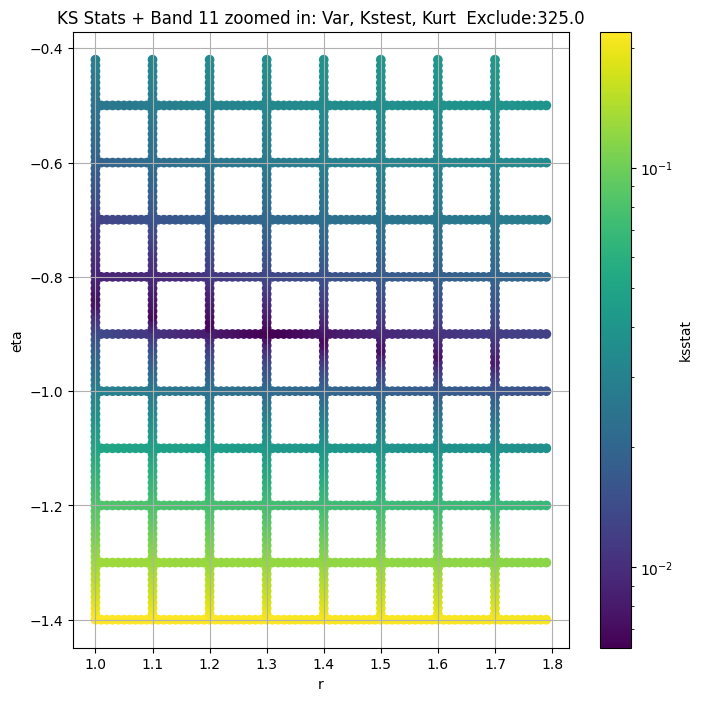

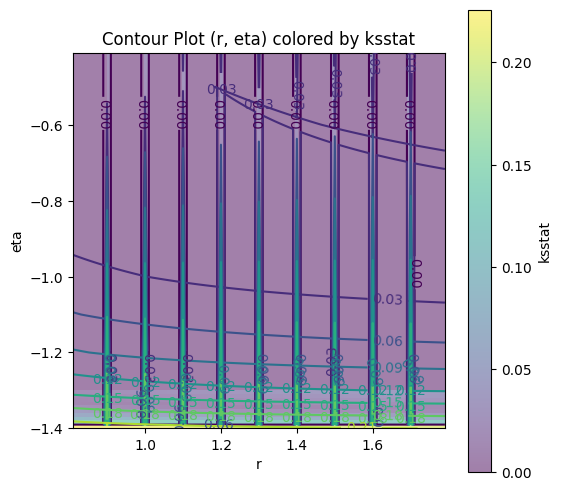

Band 14


100%|██████████| 1800/1800 [00:06<00:00, 281.66it/s]


Finding Minimum after computing 1800 CDFs
band 14, 75.0 + 100 = 175, ksstat: 0.00543614143561999, var: 9.67576789855957


100%|██████████| 1800/1800 [00:05<00:00, 300.32it/s]


Finding Minimum after computing 1800 CDFs
band 14, 75.0 + 75 = 150, ksstat: 0.005627990807767436, var: 9.809870719909668


100%|██████████| 1800/1800 [00:05<00:00, 302.06it/s]


Finding Minimum after computing 1800 CDFs
band 14, 75.0 + 50 = 125, ksstat: 0.005584225904212814, var: 9.95460033416748


100%|██████████| 1800/1800 [00:05<00:00, 301.63it/s]


Finding Minimum after computing 1800 CDFs
band 14, 75.0 + 25 = 100, ksstat: 0.0055934345945442, var: 10.113162994384766


100%|██████████| 1800/1800 [00:06<00:00, 298.58it/s]


Finding Minimum after computing 1800 CDFs
band 14, 75.0 + 0 = 75, ksstat: 0.005700249592520246, var: 10.290623664855957


100%|██████████| 1800/1800 [00:06<00:00, 299.76it/s]


Finding Minimum after computing 1800 CDFs
band 14, 75.0 + -25 = 50, ksstat: 0.006083738120470805, var: 10.49502182006836


100%|██████████| 1800/1800 [00:05<00:00, 302.60it/s]


Finding Minimum after computing 1800 CDFs
band 14, 75.0 + -50 = 25, ksstat: 0.005902003634043584, var: 10.746617317199707


100%|██████████| 1800/1800 [00:05<00:00, 302.65it/s]


Finding Minimum after computing 1800 CDFs
band 14, 75.0 + -75 = 0, ksstat: 0.006375886268310205, var: 11.219242095947266
Number of samples: 100000, Without approximation : 2727602.0


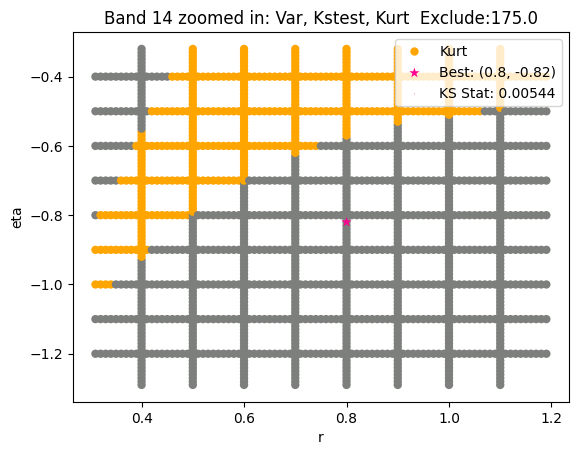

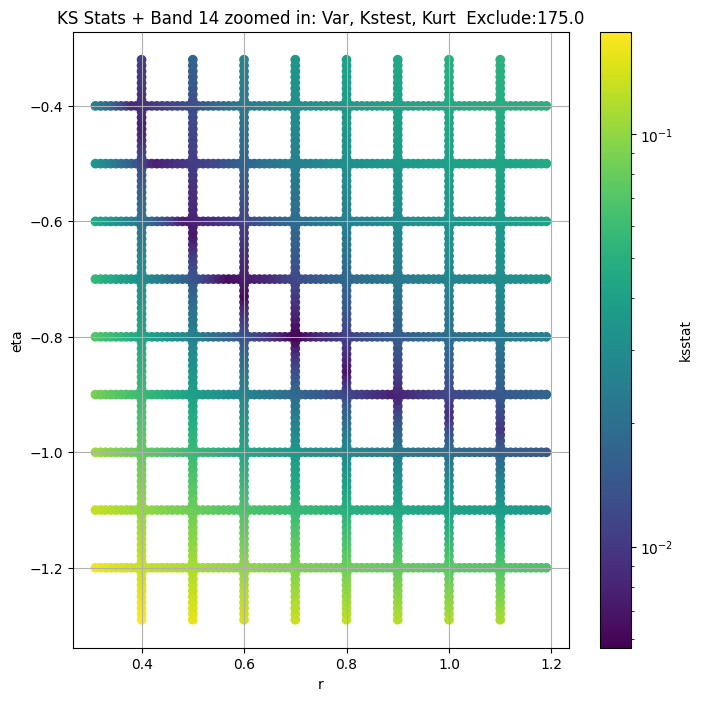

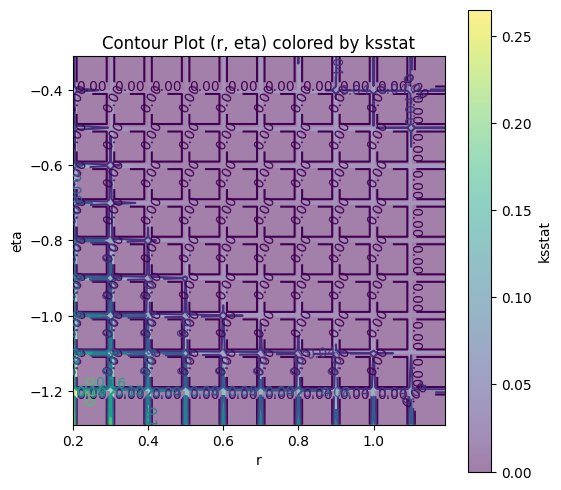

Band 17


100%|██████████| 1440/1440 [00:05<00:00, 287.42it/s]


Finding Minimum after computing 1440 CDFs
band 17, 50.0 + 100 = 150, ksstat: 0.0037598409519740694, var: 2.346224308013916


100%|██████████| 1440/1440 [00:05<00:00, 282.42it/s]


Finding Minimum after computing 1440 CDFs
band 17, 50.0 + 75 = 125, ksstat: 0.0036422321972615634, var: 2.382976531982422


100%|██████████| 1440/1440 [00:04<00:00, 301.06it/s]


Finding Minimum after computing 1440 CDFs
band 17, 50.0 + 50 = 100, ksstat: 0.0037225515665578746, var: 2.423400402069092


100%|██████████| 1440/1440 [00:04<00:00, 300.17it/s]


Finding Minimum after computing 1440 CDFs
band 17, 50.0 + 25 = 75, ksstat: 0.003763489241656537, var: 2.468834400177002


100%|██████████| 1440/1440 [00:04<00:00, 297.93it/s]


Finding Minimum after computing 1440 CDFs
band 17, 50.0 + 0 = 50, ksstat: 0.004131002704939268, var: 2.5218091011047363


100%|██████████| 1440/1440 [00:04<00:00, 300.15it/s]


Finding Minimum after computing 1440 CDFs
band 17, 50.0 + -25 = 25, ksstat: 0.004275511101246132, var: 2.5882513523101807


100%|██████████| 1440/1440 [00:04<00:00, 302.37it/s]


Finding Minimum after computing 1440 CDFs
band 17, 50.0 + -50 = 0, ksstat: 0.004643389752662652, var: 2.75986385345459
Number of samples: 100000, Without approximation : 8298440.0


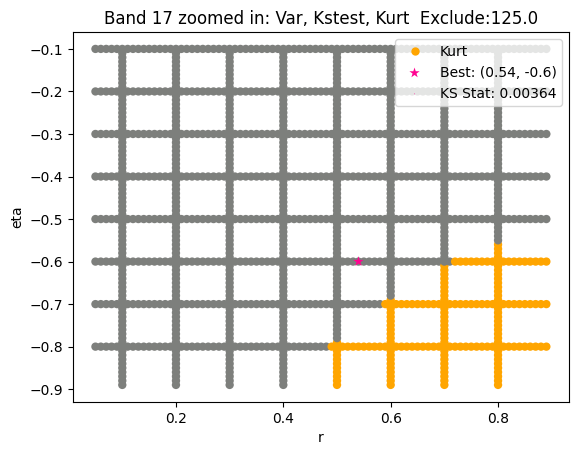

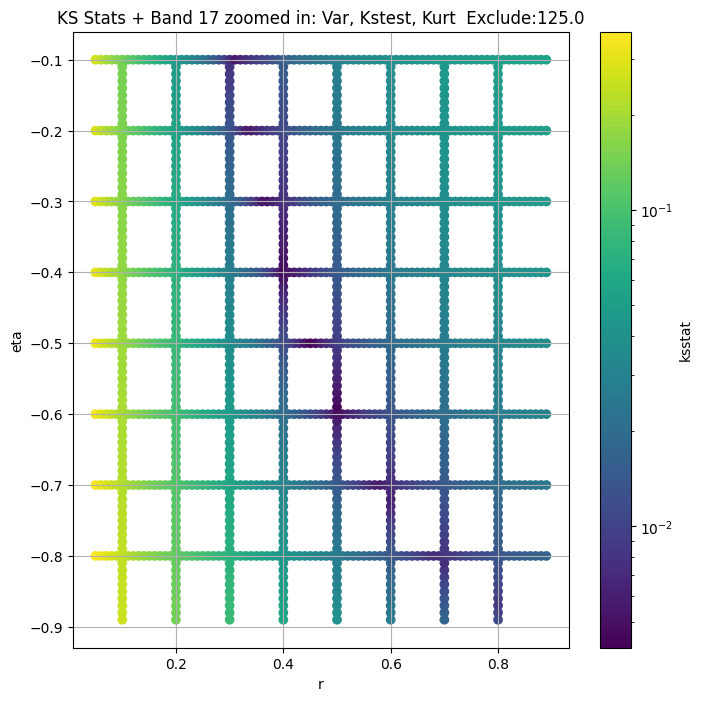

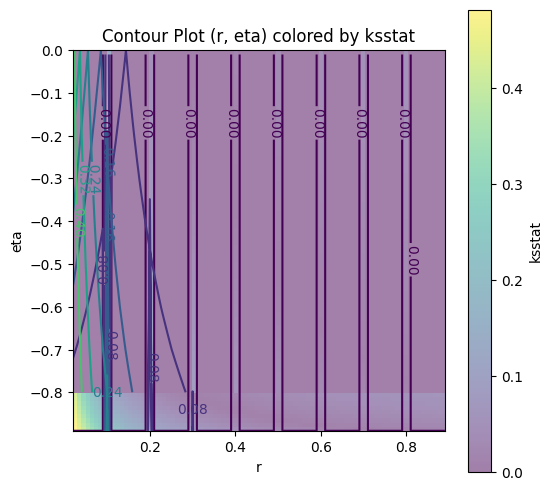

Band 20


100%|██████████| 580/580 [00:02<00:00, 269.74it/s]


Finding Minimum after computing 580 CDFs
band 20, 25.0 + 100 = 125, ksstat: 0.004588963925806433, var: 0.37559324502944946


100%|██████████| 580/580 [00:01<00:00, 303.56it/s]


Finding Minimum after computing 580 CDFs
band 20, 25.0 + 75 = 100, ksstat: 0.004174618205857961, var: 0.3820793032646179


100%|██████████| 580/580 [00:01<00:00, 302.92it/s]


Finding Minimum after computing 580 CDFs
band 20, 25.0 + 50 = 75, ksstat: 0.0035813582274476508, var: 0.3894161880016327


100%|██████████| 580/580 [00:01<00:00, 296.12it/s]


Finding Minimum after computing 580 CDFs
band 20, 25.0 + 25 = 50, ksstat: 0.0029613182342537736, var: 0.39803749322891235


100%|██████████| 580/580 [00:01<00:00, 301.92it/s]


Finding Minimum after computing 580 CDFs
band 20, 25.0 + 0 = 25, ksstat: 0.002255273123471402, var: 0.40903419256210327


100%|██████████| 580/580 [00:02<00:00, 254.40it/s]


Finding Minimum after computing 580 CDFs
band 20, 25.0 + -25 = 0, ksstat: 0.0026773968675741916, var: 0.4574565291404724
Number of samples: 100000, Without approximation : 25140192.0


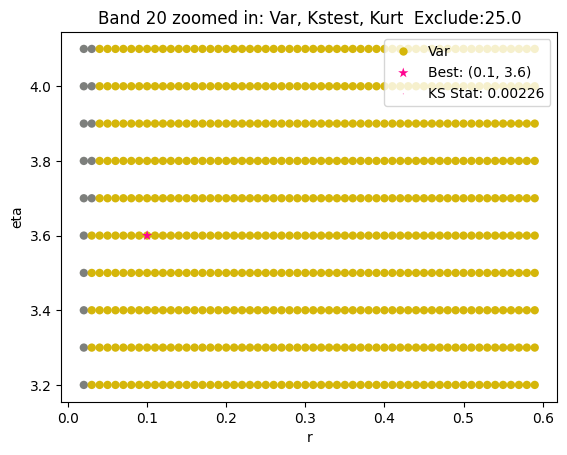

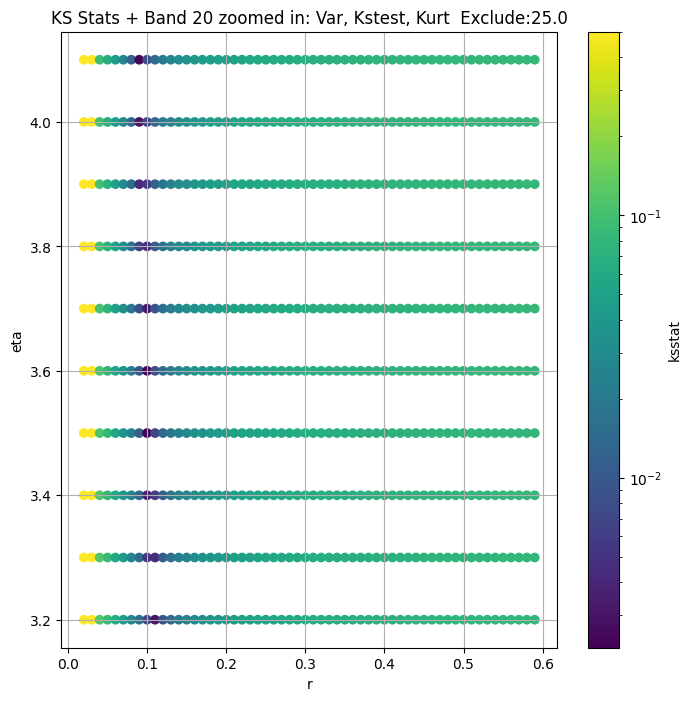

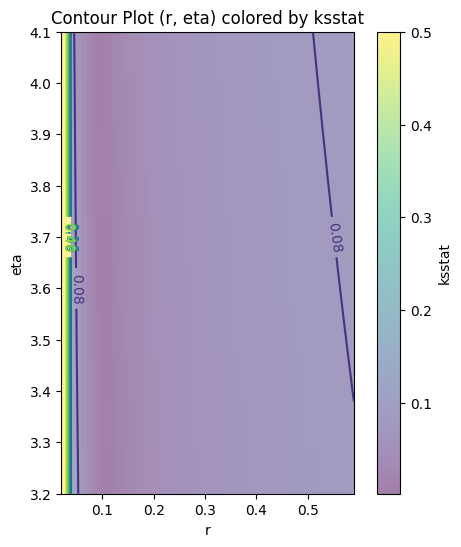

Band 23


100%|██████████| 522/522 [00:01<00:00, 268.20it/s]


Finding Minimum after computing 522 CDFs
band 23, 25.0 + 100 = 125, ksstat: 0.004239626596817425, var: 0.09649045765399933


100%|██████████| 522/522 [00:01<00:00, 301.87it/s]


Finding Minimum after computing 522 CDFs
band 23, 25.0 + 75 = 100, ksstat: 0.0038204096940221977, var: 0.09783241152763367


100%|██████████| 522/522 [00:01<00:00, 301.80it/s]


Finding Minimum after computing 522 CDFs
band 23, 25.0 + 50 = 75, ksstat: 0.0033241687639097295, var: 0.09931868314743042


100%|██████████| 522/522 [00:01<00:00, 300.11it/s]


Finding Minimum after computing 522 CDFs
band 23, 25.0 + 25 = 50, ksstat: 0.002784692697578417, var: 0.1010131910443306


100%|██████████| 522/522 [00:01<00:00, 286.15it/s]


Finding Minimum after computing 522 CDFs
band 23, 25.0 + 0 = 25, ksstat: 0.0022049165019991657, var: 0.10307153314352036


100%|██████████| 522/522 [00:01<00:00, 300.06it/s]


Finding Minimum after computing 522 CDFs
band 23, 25.0 + -25 = 0, ksstat: 0.002556478761552461, var: 0.10886135697364807
Number of samples: 100000, Without approximation : 65734528.0


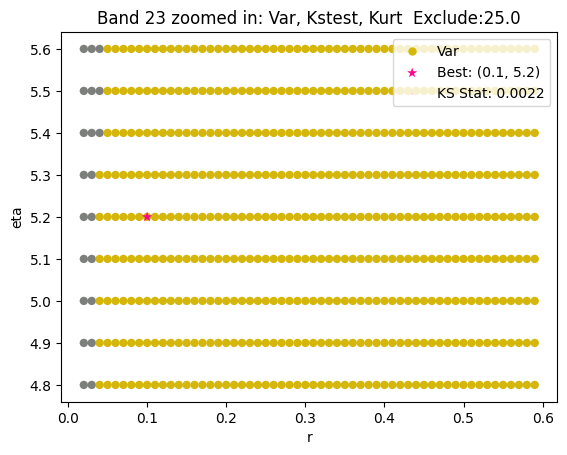

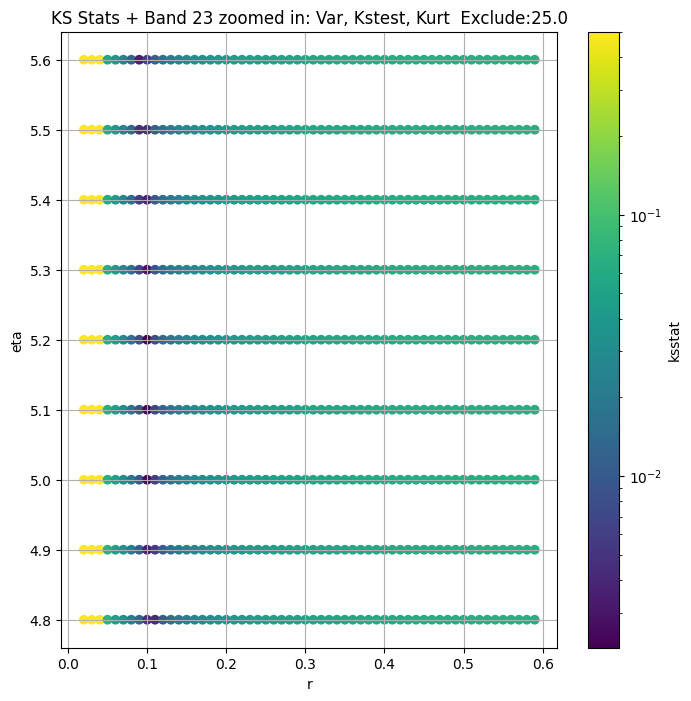

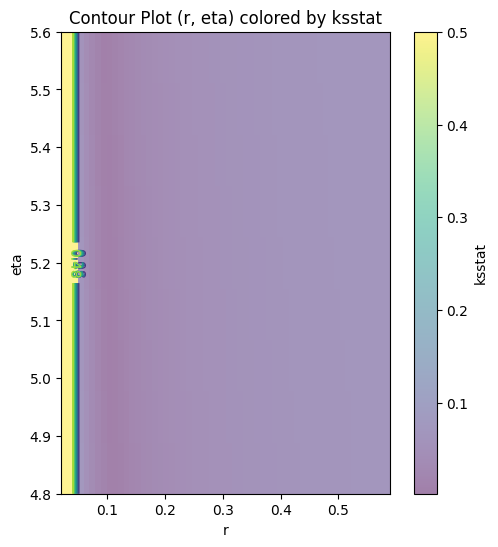

obs_var    var_lower    var_upper    obs_kurt  kurt_lower  \
band                                                                  
2     1317.523100  1225.378300  1416.404900    5.938153    4.311650   
5      529.166600   484.306500   580.238650   10.238717    6.227644   
8      152.612470   139.443650   167.750700   10.654584    6.318540   
11      38.099050    34.947570    41.571890    9.481829    6.036282   
14      11.219242    10.258306    12.378116   11.123092    6.303248   
17       2.759864     2.472387     3.437130   38.040096    6.955560   
20       0.457457     0.391537     0.766863  212.946980    7.135597   
23       0.108861     0.098681     0.137802   38.076750    4.879170   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2       8.405162        47614.0             0.006505        3.2         -0.9   
5      16.210070       102030.0             0.008649        1.4         -0.9   
8      24.114677       326496.0             0.007217        1.5         -0.9   
11     16.780167       904666.0             0.006294        1.3         -0.9   
14     29.718310      2727602.0             0.005700        0.7         -0.8   
17    230.069370      8298440.0             0.004440        0.4         -0.4   
20    983.588300     25140192.0             0.002255        0.1          3.6   
23    234.754040     65734528.0             0.002205        0.1          5.2   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      3.203187e+03                   100.0         1155.111000   
5      9.879908e+02                   200.0          452.793182   
8      2.775865e+02                   350.0          119.656715   
11     6.698871e+01                   250.0           30.781301   
14     8.129588e+00                    75.0            9.675768   
17     1.151886e-01                    50.0            2.382977   
20     1.495063e-18                    25.0            0.409034   
23     2.975689e-20                    25.0            0.103072   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.006220          0.006505    3.20     -0.90   
5                    0.004250          0.008240    1.60     -0.92   
8                    0.002376          0.006825    1.80     -0.92   
11                   0.001428          0.006173    1.50     -0.91   
14                   0.000822          0.005436    0.80     -0.82   
17                   0.000471          0.003642    0.54     -0.60   
20                   0.000271          0.002255    0.10      3.60   
23                   0.000168          0.002205    0.10      5.20   

        best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                  
2     3.203187e+03                100.0        45193  
5     1.103498e+03                175.0        28695  
8     3.054698e+02                375.0        40812  
11    7.170638e+01                325.0        47704  
14    1.028598e+01                175.0        63927  
17    6.341794e-01                125.0       145870  
20    1.495063e-18                 25.0       372864  
23    2.975689e-20                 25.0       385162

In [ ]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

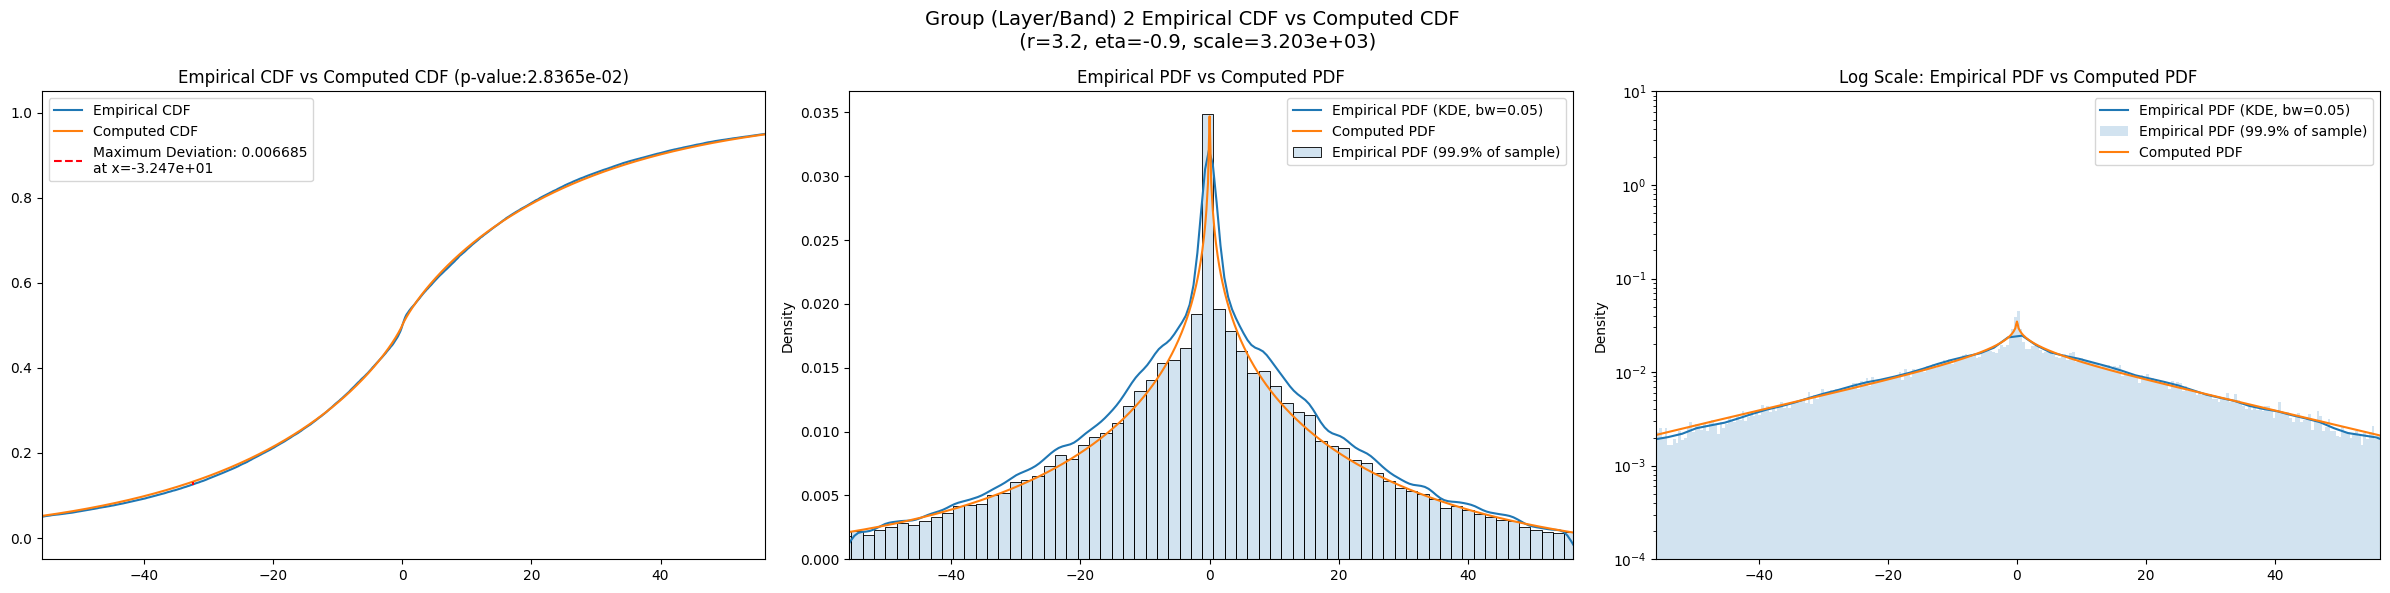

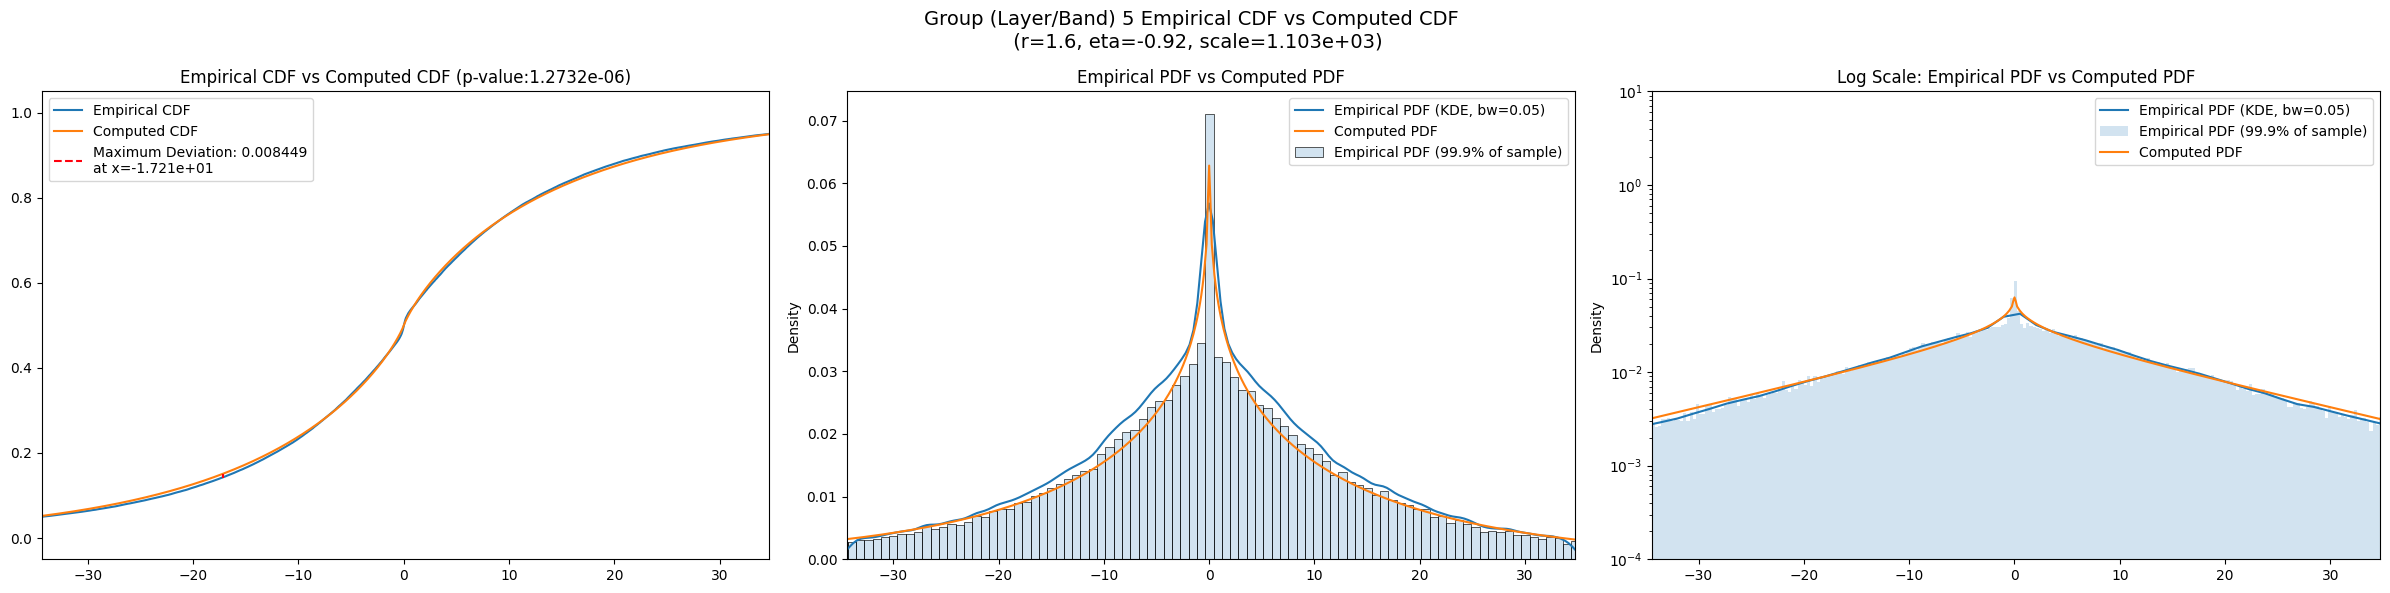

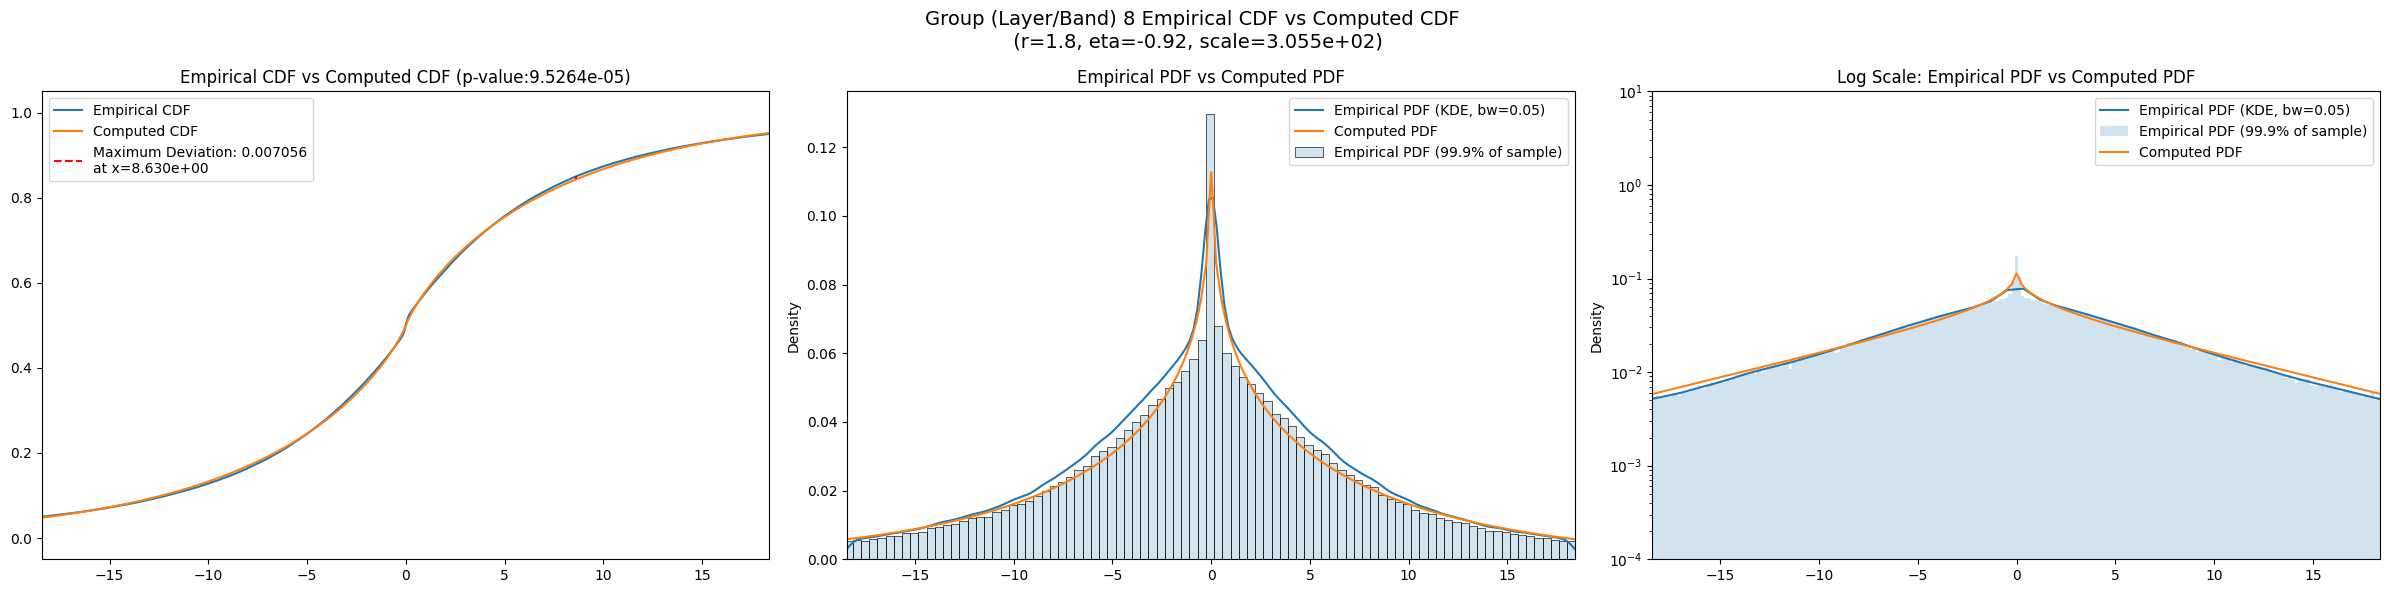

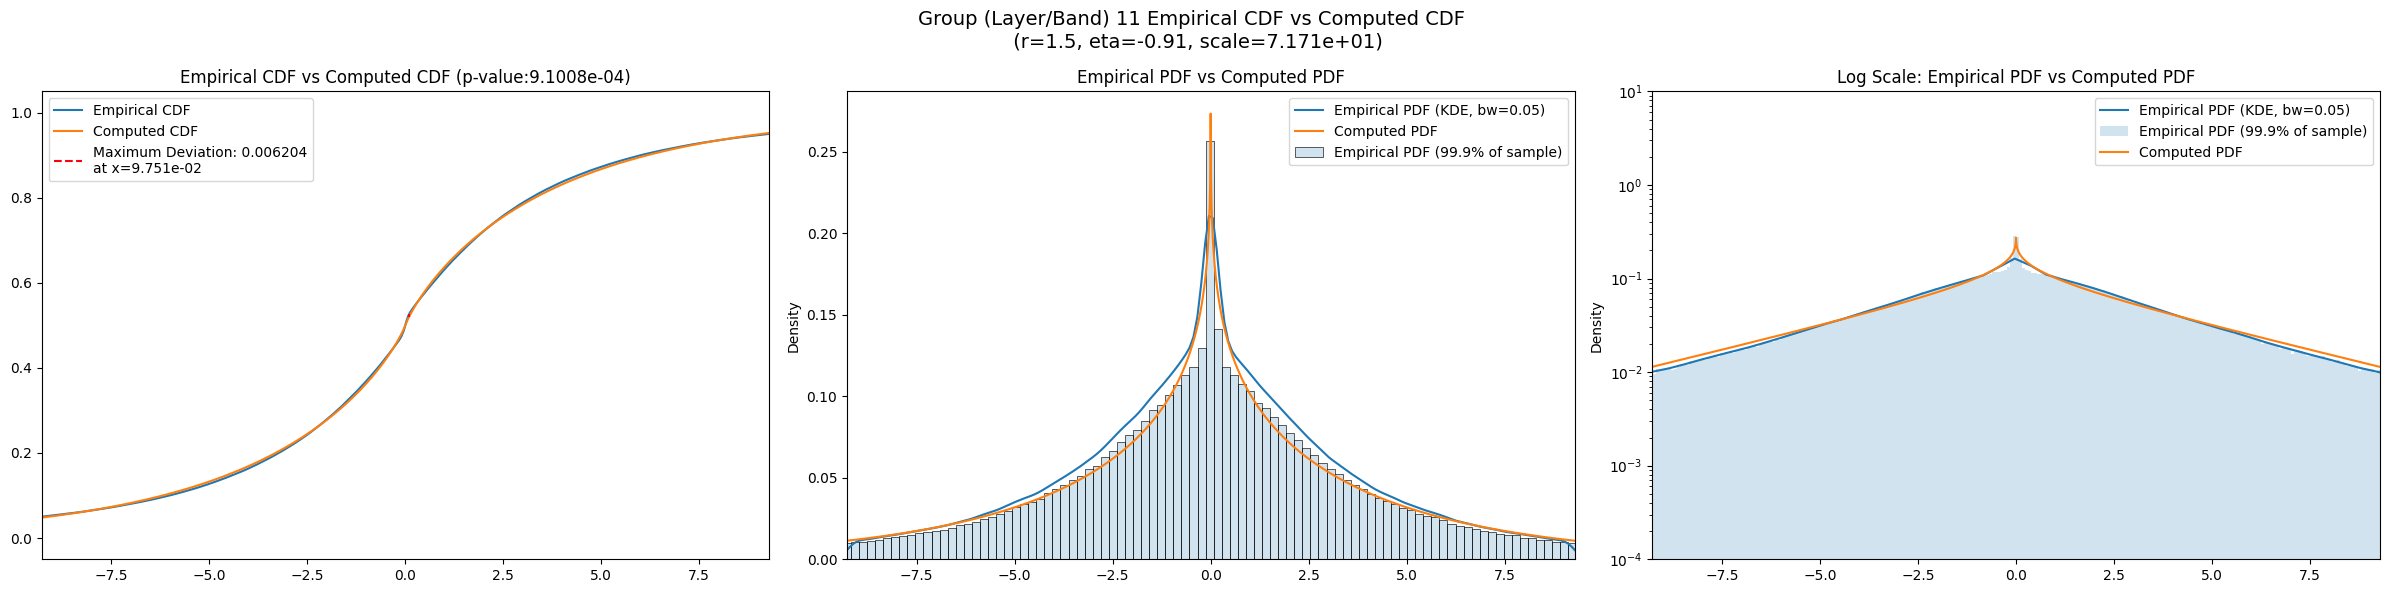

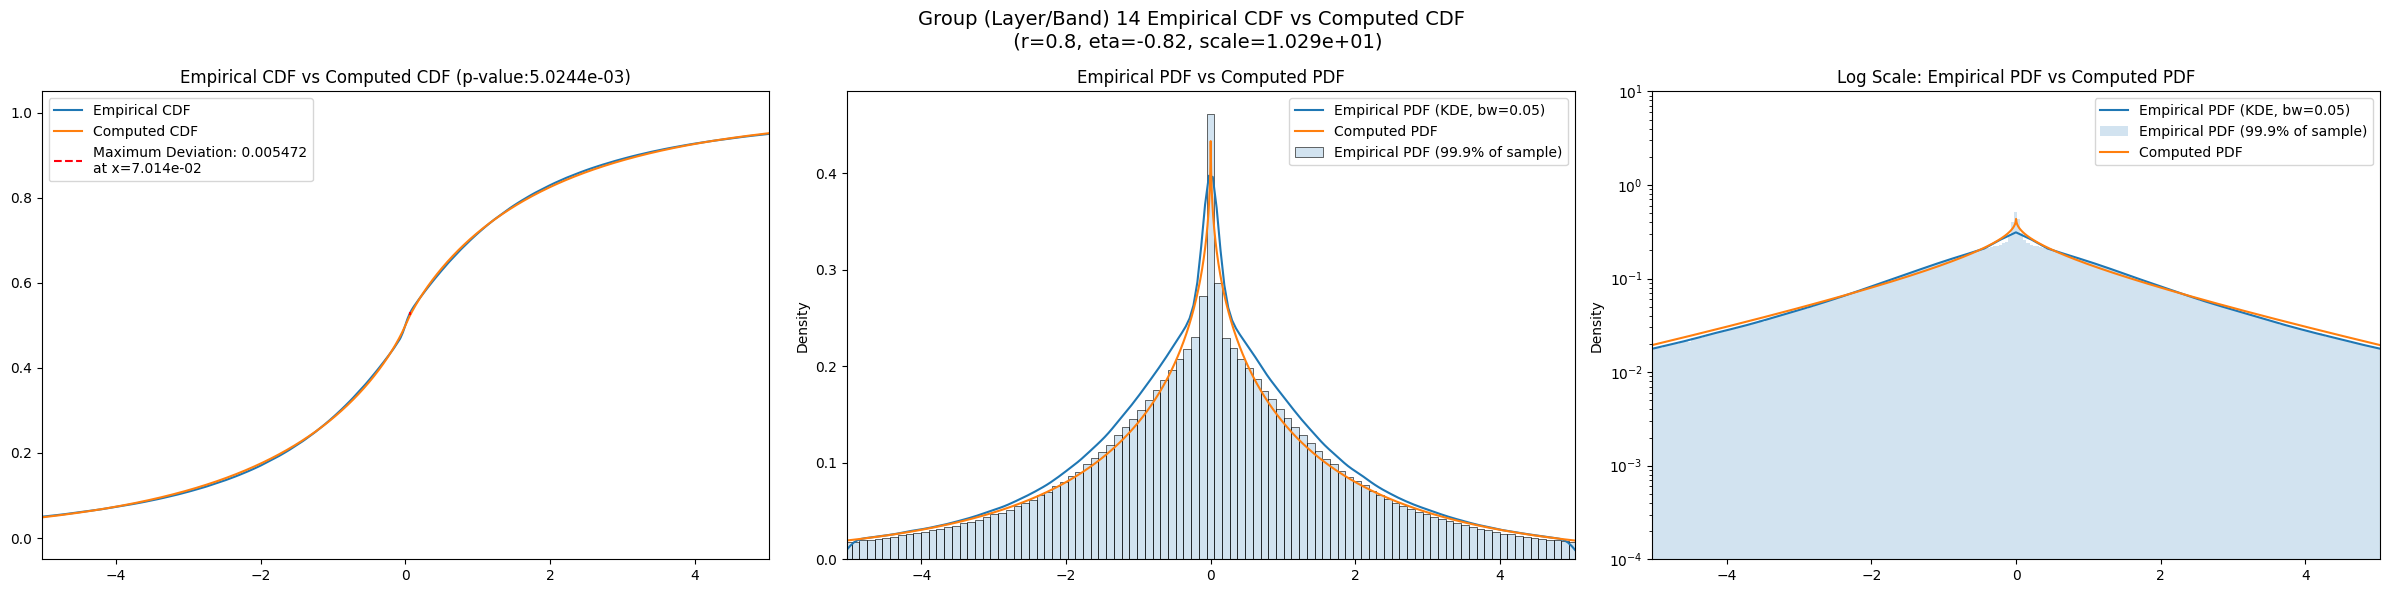

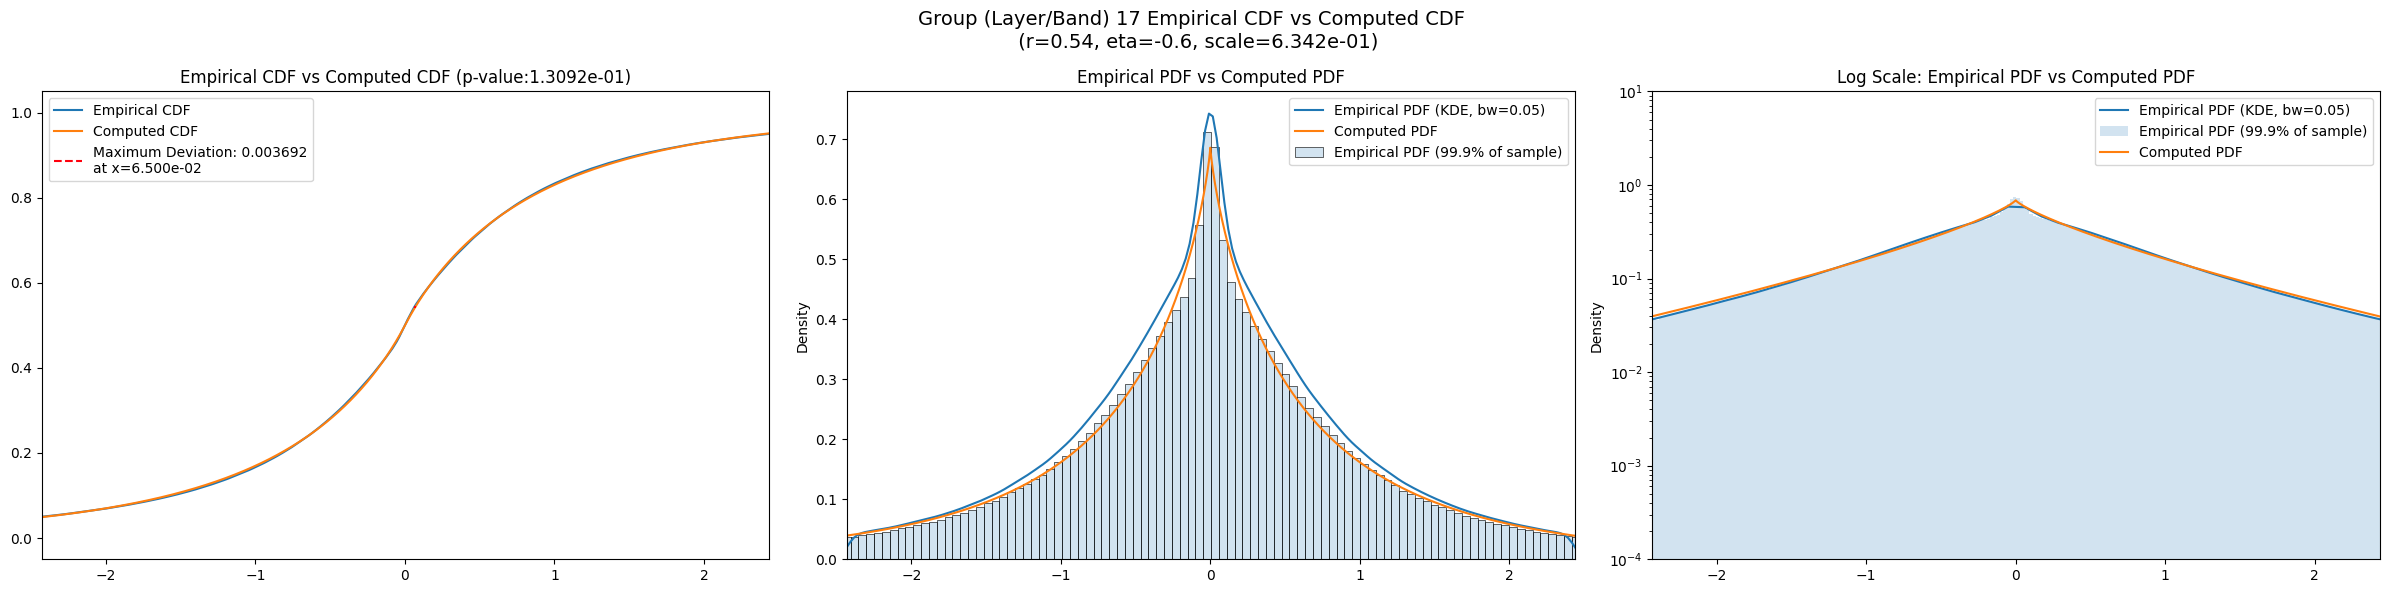

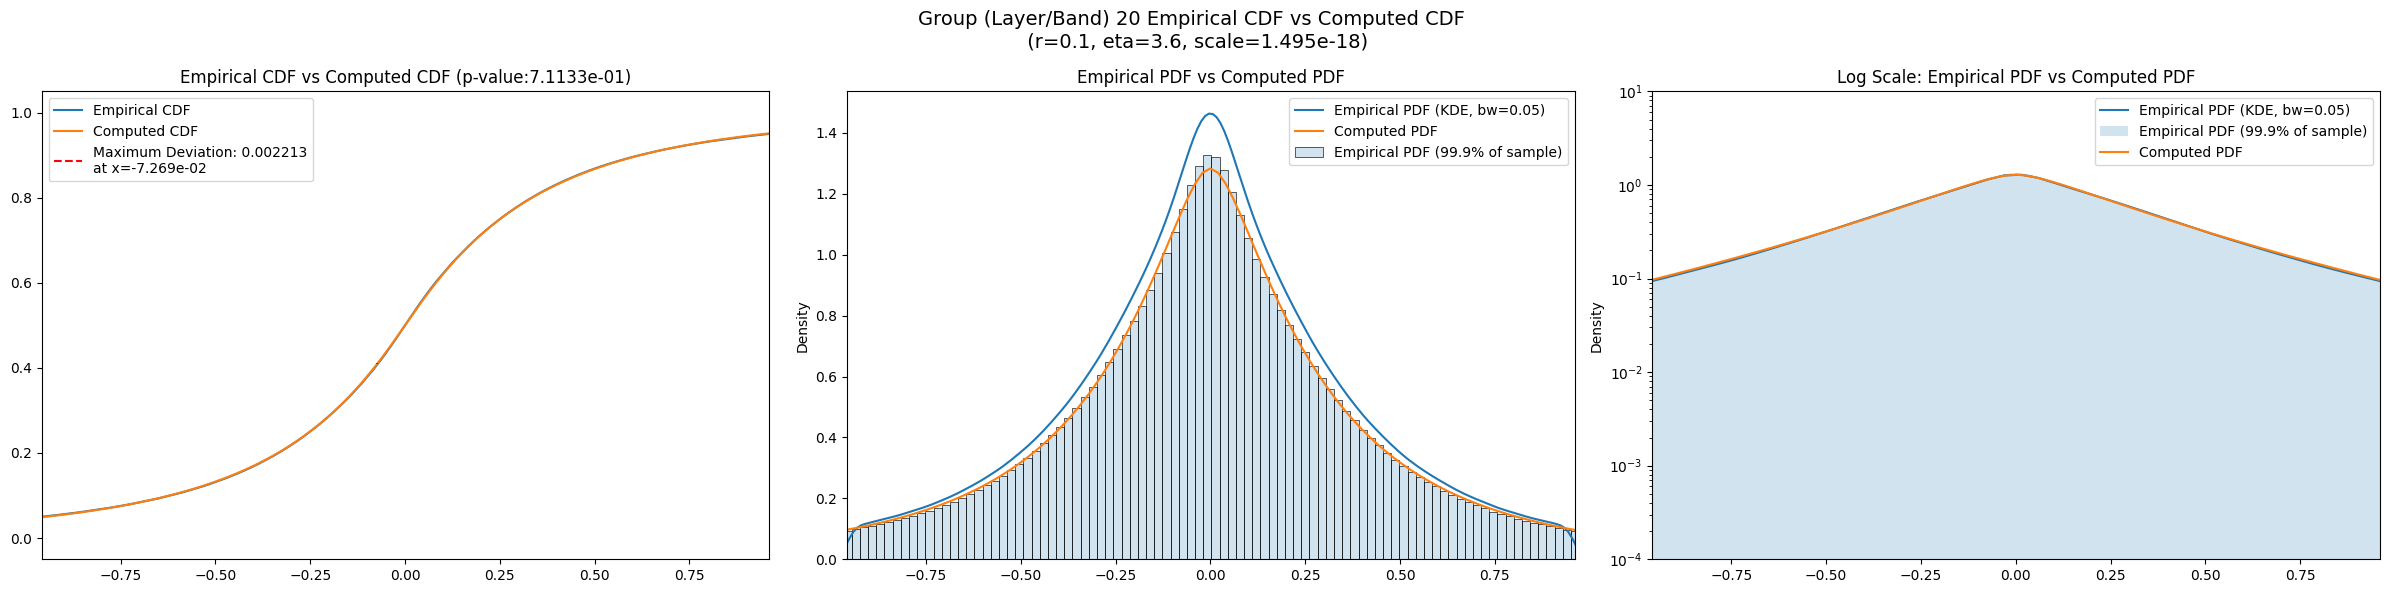

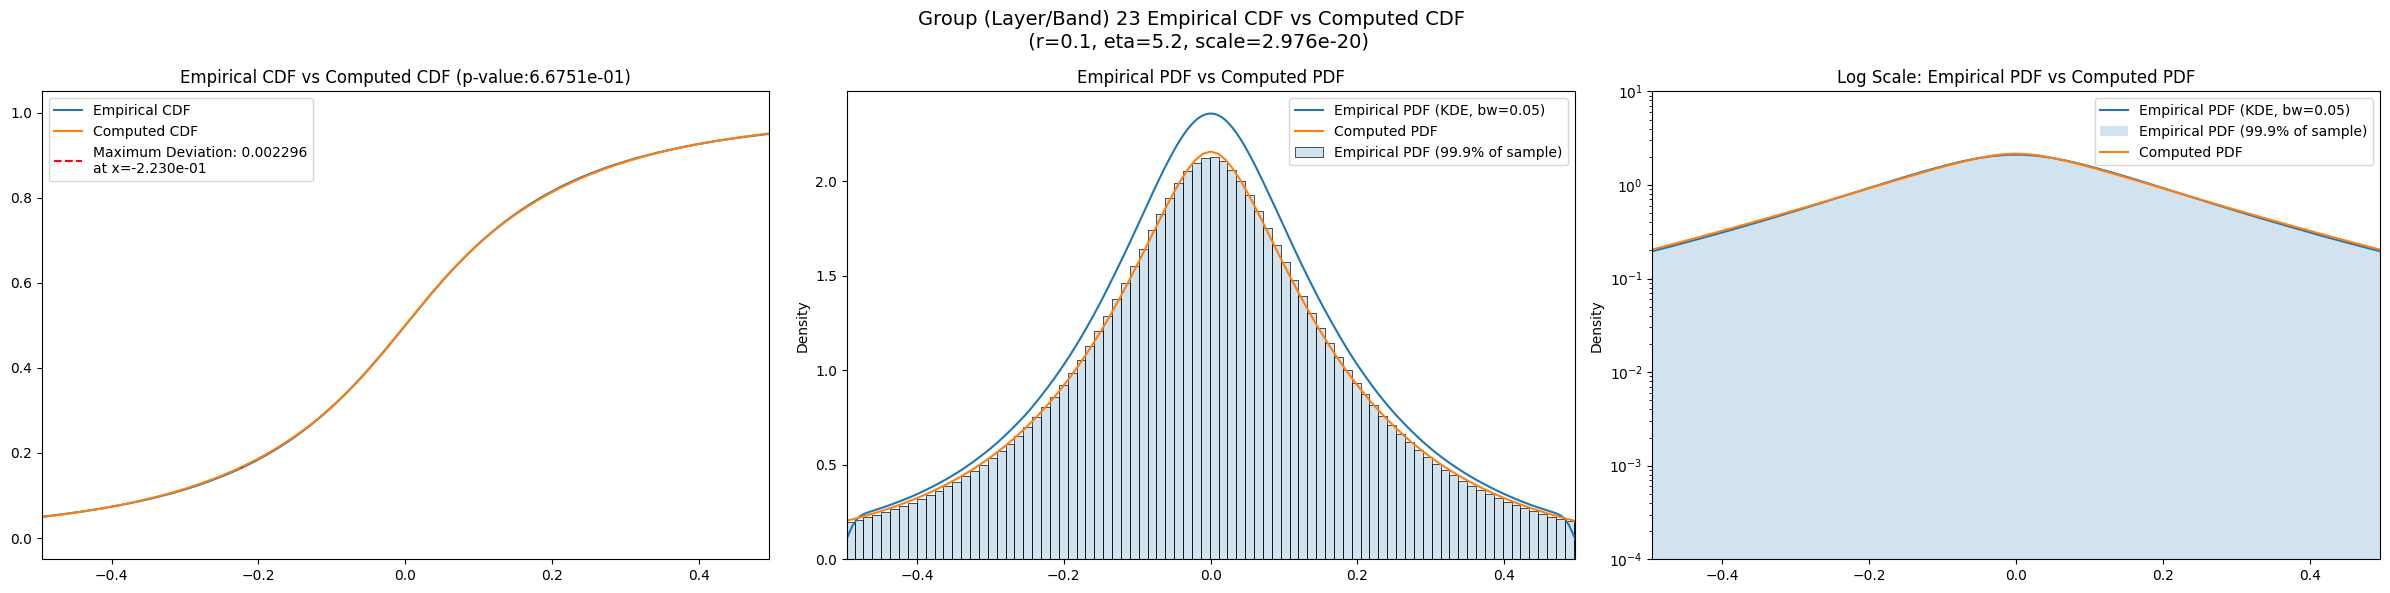

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper    obs_kurt  kurt_lower  \
band                                                                  
2     1317.523100  1225.378300  1416.404900    5.938153    4.311650   
5      529.166600   484.306500   580.238650   10.238717    6.227644   
8      152.612470   139.443650   167.750700   10.654584    6.318540   
11      38.099050    34.947570    41.571890    9.481829    6.036282   
14      11.219242    10.258306    12.378116   11.123092    6.303248   
17       2.759864     2.472387     3.437130   38.040096    6.955560   
20       0.457457     0.391537     0.766863  212.946980    7.135597   
23       0.108861     0.098681     0.137802   38.076750    4.879170   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2       8.405162        47614.0             0.006505        3.2         -0.9   
5      16.210070       102030.0             0.008649        1.4         -0.9   
8      24.114677       326496.0             0.007217        1.5         -0.9   
11     16.780167       904666.0             0.006294        1.3         -0.9   
14     29.718310      2727602.0             0.005700        0.7         -0.8   
17    230.069370      8298440.0             0.004440        0.4         -0.4   
20    983.588300     25140192.0             0.002255        0.1          3.6   
23    234.754040     65734528.0             0.002205        0.1          5.2   

      ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band  ...                                                               
2     ...       26.551200              0.034521          9.809910e-50   
5     ...       15.689500              0.038255         3.589890e-130   
8     ...        8.311170              0.038098          0.000000e+00   
11    ...        4.159390              0.038488          0.000000e+00   
14    ...        2.188000              0.041127          0.000000e+00   
17    ...        1.071030              0.040088          0.000000e+00   
20    ...        0.436822              0.036870          0.000000e+00   
23    ...        0.240468              0.030878          0.000000e+00   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
band                                                                       
2         22.227800             0.013030         1.883500e-07  18.657100   
5         13.133500             0.015208         6.296090e-21  10.892800   
8          7.087550             0.013518         2.969630e-52   5.756650   
11         3.563010             0.013782        1.098330e-149   2.865080   
14         1.917280             0.014576         0.000000e+00   1.504440   
17         0.945254             0.013210         0.000000e+00   0.739511   
20         0.385387             0.010881         0.000000e+00   0.307329   
23         0.208616             0.006637         0.000000e+00   0.170376   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.017236   1.021520e-12          3.541204e-02  
5          0.018400   1.942210e-30          1.914073e-06  
8          0.016281   1.330270e-75          1.228215e-13  
11         0.016450  4.506960e-213          2.279254e-30  
14         0.017202   0.000000e+00          1.935352e-70  
17         0.015692   0.000000e+00          4.792624e-96  
20         0.009767   0.000000e+00         1.715391e-111  
23         0.005127   0.000000e+00         5.222131e-278  

[8 rows x 30 columns]

## Results

In [8]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [ ]:
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.006505                 0.006220          0.006505   
5                0.008649                 0.004250          0.008240   
8                0.007217                 0.002376          0.006825   
11               0.006294                 0.001428          0.006173   
14               0.005700                 0.000822          0.005436   
17               0.004440                 0.000471          0.003642   
20               0.002255                 0.000271          0.002255   
23               0.002205                 0.000168          0.002205   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.034521             0.013030       0.017236  
5                 0.038255             0.015208       0.018400  
8                 0.038098             0.013518       0.016281  
11                0.038488             0.013782       0.016450  
14                0.041127             0.014576       0.017202  
17                0.040088             0.013210       0.015692  
20                0.036870             0.010881       0.009767  
23                0.030878             0.006637       0.005127

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
band                                                                         
2            1155.111000          0.006505    3.20     -0.90  3.203187e+03   
5             452.793182          0.008240    1.60     -0.92  1.103498e+03   
8             119.656715          0.006825    1.80     -0.92  3.054698e+02   
11             30.781301          0.006173    1.50     -0.91  7.170638e+01   
14              9.675768          0.005436    0.80     -0.82  1.028598e+01   
17              2.382977          0.003642    0.54     -0.60  6.341794e-01   
20              0.409034          0.002255    0.10      3.60  1.495063e-18   
23              0.103072          0.002205    0.10      5.20  2.975689e-20   

      best_exclude_cutoff  
band                       
2                   100.0  
5                   175.0  
8                   375.0  
11                  325.0  
14                  175.0  
17                  125.0  
20                   25.0  
23                   25.0

In [21]:
eng.quit()